<CENTER>

# PROJETO FINAL
    
# CHURN PREDICT - TELECOMUNICAÇÃO

# IMPORTAÇÃO DAS BIBLIOTECAS

In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import shap

# pre-processamento
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from imblearn.over_sampling import SMOTE

# treinamento de modelos 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from tensorflow import keras
from sklearn.cluster import KMeans

# métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.decomposition import PCA

# CARREGAMENTO E VISUALIZAÇÃO DOS DADOS

## Contract

In [2]:
df_contract = pd.read_csv('./final_provider/contract.csv')

df_contract.head(5)

customerID   BeginDate              EndDate            Type  \
0  7590-VHVEG  2020-01-01                   No  Month-to-month   
1  5575-GNVDE  2017-04-01                   No        One year   
2  3668-QPYBK  2019-10-01  2019-12-01 00:00:00  Month-to-month   
3  7795-CFOCW  2016-05-01                   No        One year   
4  9237-HQITU  2019-09-01  2019-11-01 00:00:00  Month-to-month   

  PaperlessBilling              PaymentMethod  MonthlyCharges TotalCharges  
0              Yes           Electronic check           29.85        29.85  
1               No               Mailed check           56.95       1889.5  
2              Yes               Mailed check           53.85       108.15  
3               No  Bank transfer (automatic)           42.30      1840.75  
4              Yes           Electronic check           70.70       151.65

In [3]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [4]:
# Função para conversão dos nomes das colunas para snake_case

def to_snake_case(df):
    
    # Criando a variável columns_new com os nomes das colunas em uma lista
    columns_new = df.columns

    # Transformando em string para poder usar regex
    string_columns = '/'.join(columns_new)

    # Usando Regex para alterar as strings inserindo um espaço antes das letras maiúsculas
    regex_columns = re.sub('(?=[A-Z])', ' ', string_columns)
    regex_columns = regex_columns.split('/')
    
    
    new_col_names = []

    for name in regex_columns:
        name_stripped = name.strip()
        name_lowered = name_stripped.lower()
        name_no_spaces = name_lowered.replace(' ', '_')
    
        new_col_names.append(name_no_spaces)

    # Renomeando as colunas do DataFrame com os nomes modificados
    df.columns = new_col_names

In [5]:
to_snake_case(df_contract)

df_contract.columns

Index(['customer_i_d', 'begin_date', 'end_date', 'type', 'paperless_billing',
       'payment_method', 'monthly_charges', 'total_charges'],
      dtype='object')

In [6]:
# Conversão da coluna 'begin_date' para datetime
df_contract['begin_date'] = pd.to_datetime(df_contract['begin_date'], format = '%Y-%m-%d')

In [7]:
# Conversão da coluna 'end_date' para datetime
df_contract['end_date'] = df_contract['end_date'].apply(lambda x : None if x == "No" else x)
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], format = '%Y-%m-%d %H:%M:%S')
df_contract['end_date'] = pd.to_datetime(df_contract['end_date'], format = '%Y-%m-%d')

In [8]:
# Conversão da coluna 'total_charges' para float
df_contract['total_charges'] = pd.to_numeric(df_contract['total_charges'], errors='coerce')

In [9]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_i_d       7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
dtypes: datetime64[ns](2), float64(2), object(4)
memory usage: 440.3+ KB


In [10]:
# Checagem de duplicados
df_contract.duplicated().sum()

0

## Internet

In [11]:
df_internet = pd.read_csv('./final_provider/internet.csv')

df_internet.head(5)

customerID InternetService OnlineSecurity OnlineBackup DeviceProtection  \
0  7590-VHVEG             DSL             No          Yes               No   
1  5575-GNVDE             DSL            Yes           No              Yes   
2  3668-QPYBK             DSL            Yes          Yes               No   
3  7795-CFOCW             DSL            Yes           No              Yes   
4  9237-HQITU     Fiber optic             No           No               No   

  TechSupport StreamingTV StreamingMovies  
0          No          No              No  
1          No          No              No  
2          No          No              No  
3         Yes          No              No  
4          No          No              No

In [12]:
# Conversão dos nomes das colunas para snake_case
to_snake_case(df_internet)

df_internet.columns

Index(['customer_i_d', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_t_v',
       'streaming_movies'],
      dtype='object')

In [13]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   customer_i_d       5517 non-null   object
 1   internet_service   5517 non-null   object
 2   online_security    5517 non-null   object
 3   online_backup      5517 non-null   object
 4   device_protection  5517 non-null   object
 5   tech_support       5517 non-null   object
 6   streaming_t_v      5517 non-null   object
 7   streaming_movies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [14]:
df_internet.duplicated().sum()

0

## Personal

In [15]:
df_personal = pd.read_csv('./final_provider/personal.csv')

df_personal.head()

customerID  gender  SeniorCitizen Partner Dependents
0  7590-VHVEG  Female              0     Yes         No
1  5575-GNVDE    Male              0      No         No
2  3668-QPYBK    Male              0      No         No
3  7795-CFOCW    Male              0      No         No
4  9237-HQITU  Female              0      No         No

In [16]:
to_snake_case(df_personal)

df_personal.columns

Index(['customer_i_d', 'gender', 'senior_citizen', 'partner', 'dependents'], dtype='object')

In [17]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_i_d    7043 non-null   object
 1   gender          7043 non-null   object
 2   senior_citizen  7043 non-null   int64 
 3   partner         7043 non-null   object
 4   dependents      7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [18]:
df_personal.duplicated().sum()

0

## Phone

In [19]:
df_phone = pd.read_csv('./final_provider/phone.csv')

df_phone.head()

customerID MultipleLines
0  5575-GNVDE            No
1  3668-QPYBK            No
2  9237-HQITU            No
3  9305-CDSKC           Yes
4  1452-KIOVK           Yes

In [20]:
to_snake_case(df_phone)

df_phone.columns

Index(['customer_i_d', 'multiple_lines'], dtype='object')

In [21]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   customer_i_d    6361 non-null   object
 1   multiple_lines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [22]:
df_phone['multiple_lines'].value_counts()

multiple_lines
No     3390
Yes    2971
Name: count, dtype: int64

In [23]:
df_phone.duplicated().sum()

0

# CONCATENAÇÃO DOS DATAFRAMES

In [24]:
df_merged = df_contract.merge(df_internet, on='customer_i_d', how='left') \
               .merge(df_personal, on='customer_i_d', how='left') \
               .merge(df_phone, on='customer_i_d', how='left')

df_merged.sample(5)

customer_i_d begin_date end_date            type paperless_billing  \
6998   0928-XUTSN 2019-01-01      NaT  Month-to-month               Yes   
2315   2577-GVSIL 2017-03-01      NaT        One year               Yes   
4540   6728-WYQBC 2020-01-01      NaT  Month-to-month                No   
6780   3640-JQGJG 2019-01-01      NaT  Month-to-month                No   
4087   3847-BAERP 2019-04-01      NaT  Month-to-month               Yes   

                 payment_method  monthly_charges  total_charges  \
6998           Electronic check            80.50        1011.80   
2315  Bank transfer (automatic)            73.45        2661.10   
4540  Bank transfer (automatic)            20.95          20.95   
6780  Bank transfer (automatic)            44.80         559.20   
4087               Mailed check            20.90         247.00   

     internet_service online_security online_backup device_protection  \
6998      Fiber optic              No            No                No   
2315              DSL              No            No                No   
4540              NaN             NaN           NaN               NaN   
6780              DSL              No            No                No   
4087              NaN             NaN           NaN               NaN   

     tech_support streaming_t_v streaming_movies  gender  senior_citizen  \
6998           No            No              Yes  Female               0   
2315          Yes           Yes              Yes    Male               0   
4540          NaN           NaN              NaN    Male               0   
6780           No            No               No    Male               0   
4087          NaN           NaN              NaN  Female               0   

     partner dependents multiple_lines  
6998      No         No             No  
2315     Yes        Yes            Yes  
4540      No         No             No  
6780     Yes        Yes             No  
4087      No         No             No

In [25]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_i_d       7043 non-null   object        
 1   begin_date         7043 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7043 non-null   object        
 4   paperless_billing  7043 non-null   object        
 5   payment_method     7043 non-null   object        
 6   monthly_charges    7043 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   internet_service   5517 non-null   object        
 9   online_security    5517 non-null   object        
 10  online_backup      5517 non-null   object        
 11  device_protection  5517 non-null   object        
 12  tech_support       5517 non-null   object        
 13  streaming_t_v      5517 non-null   object        
 14  streamin

## Checagem de dados ausentes

In [26]:
# A coluna 'total_charges' tem 11 linhas com dados ausentes. Como isso representa somente 0,1% das colunas do dataframe, essas linhas serão removidas.
df_merged = df_merged.dropna(subset=['total_charges'])

O DataFrame 'Phone' possui menos linhas que o Dataframe 'Personal', o que faz com que algumas linhas fiquem com dados ausentes. A interpretação deste Dataframe é que as linhas que ficarem com 'NaN' não tem serviço de telefone e consequentemente, também não tem 'multiple_lines'. Porém, não temos uma coluna com informações de clientes que possuem contratos de serviço telefônico e, portanto, ela deve ser criada.

### Criação coluna Phone

In [27]:
df_merged['phone'] = df_merged['multiple_lines'].apply(lambda x: 'No' if pd.isna(x) else 'Yes')

In [28]:
df_merged['phone'].value_counts()

phone
Yes    6352
No      680
Name: count, dtype: int64

Os dados ausentes na coluna 'internet_services' seguem o mesmo modelo e ocorrem devido os clientes de fato não terem os serviços descritos no df_internet, pois quando analisamos o dataframe isolado, ele não apresentava dados ausentes. Porém, por ter menos linhas, ficou com os dados ausentes após a concatenação dos dataframes. Por este motivo, os dados ausentes em todas as colunas deste dataframe serão substituídos por 'No', indicando que esses clientes não desfrutam destes serviços.

In [29]:
df_nan_internet = df_merged[df_merged['internet_service'].isna()]

df_nan_internet.head(3)

customer_i_d begin_date end_date      type paperless_billing  \
11   7469-LKBCI 2018-10-01      NaT  Two year                No   
16   8191-XWSZG 2015-10-01      NaT  One year                No   
21   1680-VDCWW 2019-02-01      NaT  One year                No   

               payment_method  monthly_charges  total_charges  \
11    Credit card (automatic)            18.95         326.80   
16               Mailed check            20.65        1022.95   
21  Bank transfer (automatic)            19.80         202.25   

   internet_service online_security  ... device_protection tech_support  \
11              NaN             NaN  ...               NaN          NaN   
16              NaN             NaN  ...               NaN          NaN   
21              NaN             NaN  ...               NaN          NaN   

   streaming_t_v streaming_movies  gender senior_citizen  partner dependents  \
11           NaN              NaN    Male              0       No         No   
16           NaN              NaN  Female              0       No         No   
21           NaN              NaN    Male              0      Yes         No   

   multiple_lines phone  
11             No   Yes  
16             No   Yes  
21             No   Yes  

[3 rows x 21 columns]

In [30]:
columns_to_fill = ['multiple_lines', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'end_date']

for col in columns_to_fill:
    df_merged[col] = df_merged[col].fillna('No')

## Adequação coluna target

Será criada uma coluna target chamada 'churn', com base nas informações contidas na coluna 'end_date'. 
Quando a coluna 'end_date' tem uma informação de data, isso significa que o cliente sofreu churn, caso contrário, significa que o contrato ainda está ativo.

In [31]:
df_merged['end_date'].unique()

array(['No', Timestamp('2019-12-01 00:00:00'),
       Timestamp('2019-11-01 00:00:00'), Timestamp('2019-10-01 00:00:00'),
       Timestamp('2020-01-01 00:00:00')], dtype=object)

In [32]:
df_merged['churn'] = df_merged['end_date'].where(df_merged['end_date'] == 'No', 'Yes')

In [33]:
churn_dict = {'No': 0, 'Yes': 1}

df_merged['churn'] = df_merged['churn'].map(churn_dict)
df_merged['churn'].head()

0    0
1    0
2    1
3    0
4    1
Name: churn, dtype: int64

In [34]:
# Convertendo novamente a coluna 'end_date' para datetime
df_merged['end_date'] = df_merged['end_date'].apply(lambda x : None if x == "No" else x)
df_merged['end_date'] = pd.to_datetime(df_merged['end_date'], format = '%Y-%m-%d %H:%M:%S')
df_merged['end_date'] = pd.to_datetime(df_merged['end_date'], format = '%Y-%m-%d')

In [35]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   customer_i_d       7032 non-null   object        
 1   begin_date         7032 non-null   datetime64[ns]
 2   end_date           1869 non-null   datetime64[ns]
 3   type               7032 non-null   object        
 4   paperless_billing  7032 non-null   object        
 5   payment_method     7032 non-null   object        
 6   monthly_charges    7032 non-null   float64       
 7   total_charges      7032 non-null   float64       
 8   internet_service   7032 non-null   object        
 9   online_security    7032 non-null   object        
 10  online_backup      7032 non-null   object        
 11  device_protection  7032 non-null   object        
 12  tech_support       7032 non-null   object        
 13  streaming_t_v      7032 non-null   object        
 14  streaming_mov

# ANÁLISE EXPLORATÓRIA DOS DADOS

In [36]:
temporal = ['begin_date', 'end_date']
numerical = ['monthly_charges', 'total_charges']
categorical = ['type', 'paperless_billing', 'payment_method', 'internet_service', 'online_security', 'online_backup', 'device_protection',
               'tech_support', 'streaming_t_v', 'streaming_movies', 'gender', 'senior_citizen', 'partner', 'dependents', 'multiple_lines', 'phone']

## Variáveis Categóricas

In [37]:
def dist_categorical(df, col_name, plot=False):
    print(pd.DataFrame({col_name: df[col_name].value_counts(),
                        "Ratio": 100 * df[col_name].value_counts() / len(df)}))
    
    if plot:
        plt.figure(figsize=(6, 4))
        sns.countplot(x=df[col_name], data=df, hue=df[col_name], palette="Blues_d", legend=False)
        plt.title(f'Distribuição de {col_name}', fontsize=14, weight='bold')
        plt.xlabel(col_name, fontsize=12)
        plt.ylabel('Contagem', fontsize=12)
        
        # Rotaciona os rótulos do eixo x, se necessário
        plt.xticks(rotation=0, fontsize=10)
        plt.yticks(fontsize=10)
        
        # Ajusta o layout para evitar sobreposição
        plt.tight_layout()
        plt.show(block=True)
    
    print("#############################################################################")

In [38]:
for col in categorical:
    dist_categorical(df_merged, col, plot=False)

                type      Ratio
type                           
Month-to-month  3875  55.105233
Two year        1685  23.961889
One year        1472  20.932878
#############################################################################
                   paperless_billing    Ratio
paperless_billing                            
Yes                             4168  59.2719
No                              2864  40.7281
#############################################################################
                           payment_method      Ratio
payment_method                                      
Electronic check                     2365  33.631968
Mailed check                         1604  22.810011
Bank transfer (automatic)            1542  21.928328
Credit card (automatic)              1521  21.629693
#############################################################################
                  internet_service      Ratio
internet_service                             
Fiber optic 

### Taxa de Churn por categoria

In [39]:
def churn_by_categorical(df, col_name, plot=False):
    print(col_name)
    churn_mean = df.groupby(col_name)['churn'].mean()
    print(pd.DataFrame({"Churn_Mean": churn_mean}))
    
    if plot:
        plt.figure(figsize=(6, 4))
        churn_mean.plot(kind='bar', color='steelblue', alpha=0.7)
        plt.title(f'Churn por {col_name}', fontsize=14, weight='bold')
        plt.xlabel(col_name, fontsize=12)
        plt.ylabel('Contagem', fontsize=12)
        
        # Rotaciona os rótulos do eixo x, se necessário
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        
        # Ajusta o layout para evitar sobreposição
        plt.tight_layout()
        plt.show(block=True)
    
    
    print('##############################################################################')

type
                Churn_Mean
type                      
Month-to-month    0.427097
One year          0.112772
Two year          0.028487


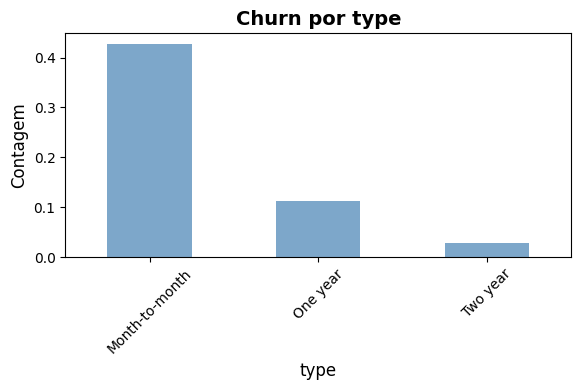

##############################################################################
paperless_billing
                   Churn_Mean
paperless_billing            
No                   0.163757
Yes                  0.335893


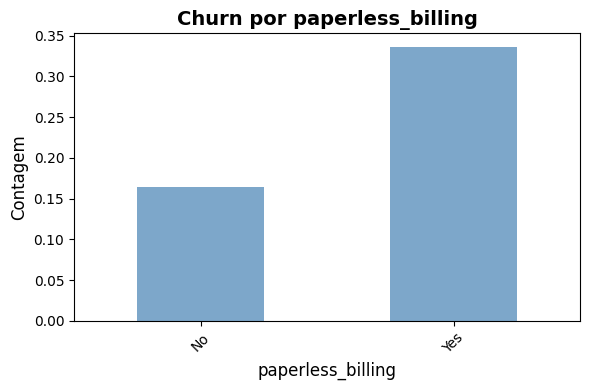

##############################################################################
payment_method
                           Churn_Mean
payment_method                       
Bank transfer (automatic)    0.167315
Credit card (automatic)      0.152531
Electronic check             0.452854
Mailed check                 0.192020


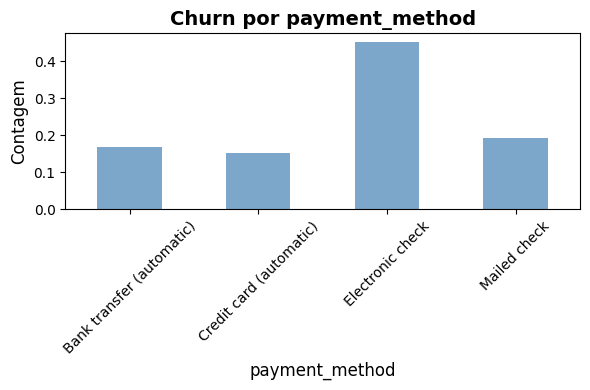

##############################################################################
internet_service
                  Churn_Mean
internet_service            
DSL                 0.189983
Fiber optic         0.418928
No                  0.074342


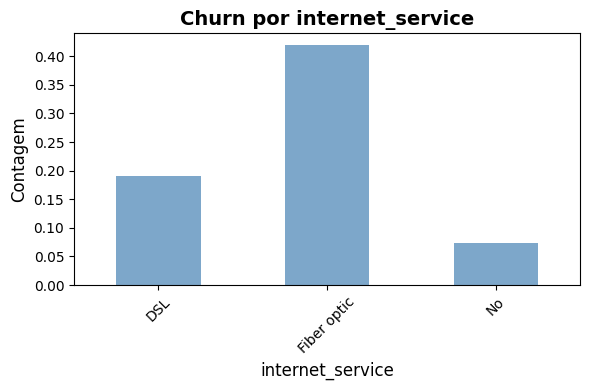

##############################################################################
online_security
                 Churn_Mean
online_security            
No                 0.313733
Yes                0.146402


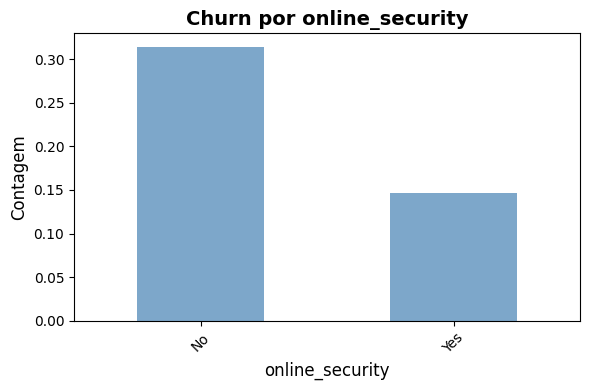

##############################################################################
online_backup
               Churn_Mean
online_backup            
No               0.292164
Yes              0.215670


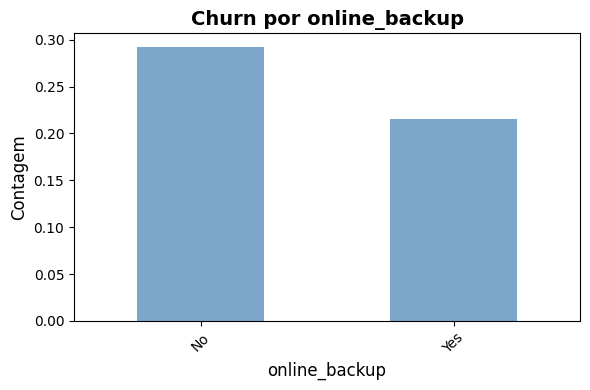

##############################################################################
device_protection
                   Churn_Mean
device_protection            
No                   0.286953
Yes                  0.225393


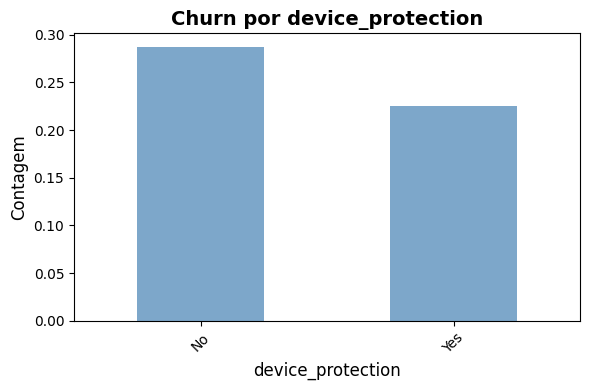

##############################################################################
tech_support
              Churn_Mean
tech_support            
No              0.312300
Yes             0.151961


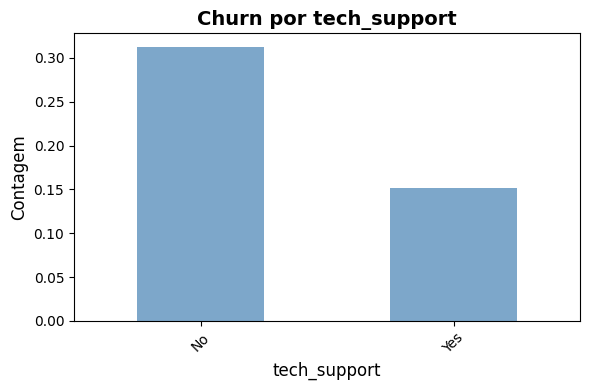

##############################################################################
streaming_t_v
               Churn_Mean
streaming_t_v            
No               0.243705
Yes              0.301147


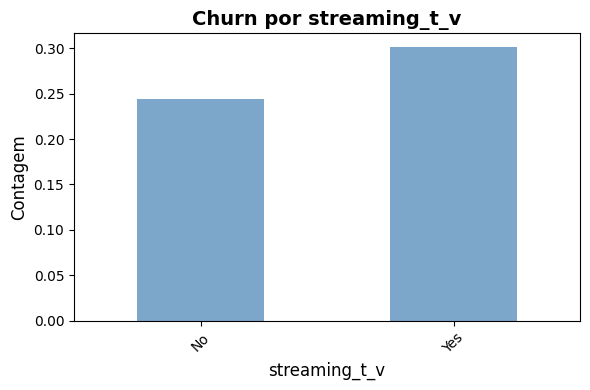

##############################################################################
streaming_movies
                  Churn_Mean
streaming_movies            
No                  0.244362
Yes                 0.299524


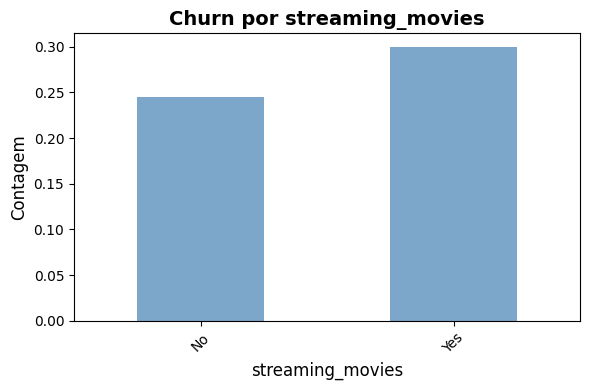

##############################################################################
gender
        Churn_Mean
gender            
Female    0.269595
Male      0.262046


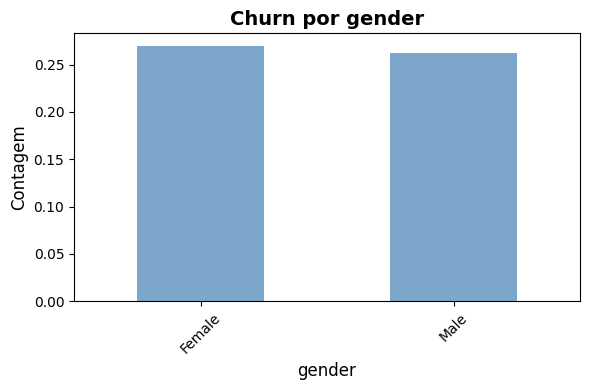

##############################################################################
senior_citizen
                Churn_Mean
senior_citizen            
0                 0.236503
1                 0.416813


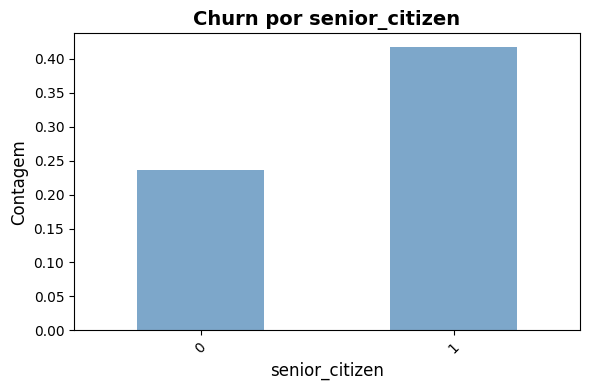

##############################################################################
partner
         Churn_Mean
partner            
No         0.329761
Yes        0.197171


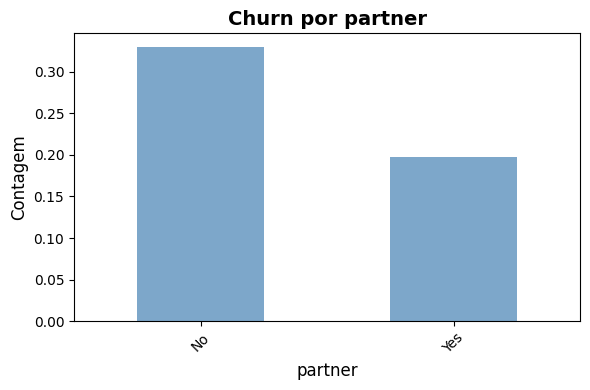

##############################################################################
dependents
            Churn_Mean
dependents            
No            0.312791
Yes           0.155312


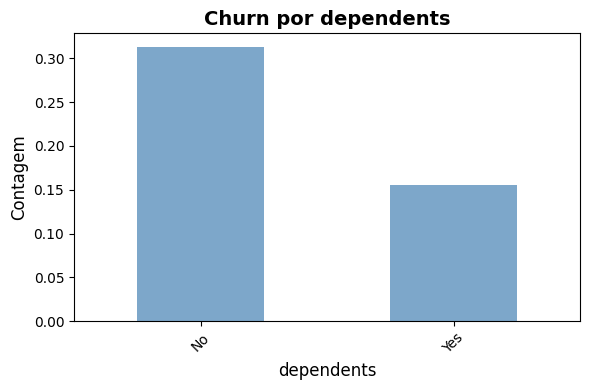

##############################################################################
multiple_lines
                Churn_Mean
multiple_lines            
No                0.250677
Yes               0.286485


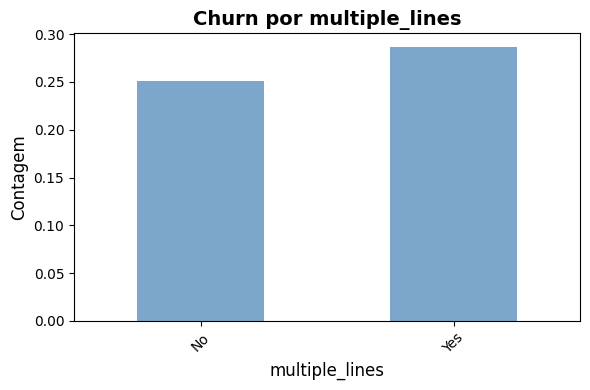

##############################################################################
phone
       Churn_Mean
phone            
No       0.250000
Yes      0.267475


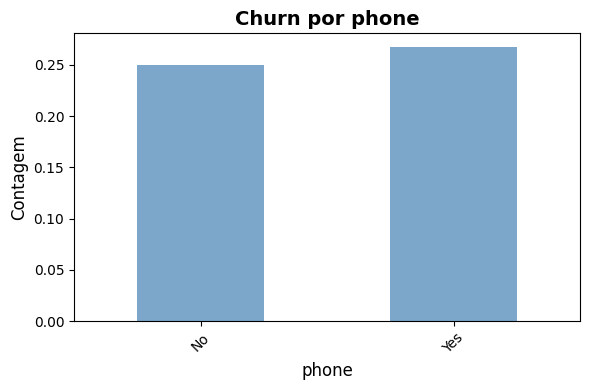

##############################################################################


In [40]:
for col in categorical:
    churn_by_categorical(df_merged, col, plot=True)

Podemos observar algumas características que impactam mais diretamente no churn do que outras, como por exemplo:

* **month_to_month**: mais de 40% dos clientes que optam por renovação de contrato mês a mês deixaram a empresa, enquanto que apenas 11% dos clientes com pacotes anuais tomaram a mesma decisão;
* **paperless_billing**: clientes que recebem seus boletos pela internet, tendem a cancelar seus contratos mais do que aqueles que recebem boletos impressos;
* **payment_method**: clientes que optam por pagamento via cheque eletrônico tendem a cancelar seus contratos quase 3x mais do que os que optam pelas outras formas de pagamento;
* **internet_service**: clientes que utilizavam o serviço de internet por fibra óptica cancelaram 2x mais o serviço do que clientes que utilizavam DSL;
* **tech_support**: clientes sem suporte técnico cancelaram o servço 2x mais do que clientes que tinham suporte técnico;
* **streaming_t_v**: clientes de streaming (tv ou filmes), tendem a cancelar um pouco mais seus contratos do que os que não contratam este tipo de serviço;
* **senior_citizen**: clientes idosos cancelaram quase o dobro de contratos em relação aos clientes não idosos (isso pode estar relacionado a outros fatores como praticidade, segurança e suporte técnico. Vamos checar essas possibilidades);
* **partner and dependents**: clientes solteiros e sem filhos tendem a cancelar mais os serviços em relação a clientes casados e com filhos. Essa questão pode estar relacionada à estabilidade, tanto financeira, quanto de residência;  


* O gênero parece não impactar nas decisões de cancelamento de contrato, pois o resultado é muito similar entre homens e mulheres

### Média de custos mensais em relação às variáveis categóricas

In [41]:
def charges_by_categorical(df, target, categorical_col):
    print(categorical_col)
    print(pd.DataFrame({"Charges_Mean": df.groupby(categorical_col)[target].mean(),
                        "Count": df[categorical_col].value_counts(),
                        "Ratio": 100 * df[categorical_col].value_counts() / len(df)}), end="\n\n\n")
    print('#######################################')

In [42]:
for col in categorical:
    charges_by_categorical(df_merged, "monthly_charges", col)

type
                Charges_Mean  Count      Ratio
type                                          
Month-to-month     66.398490   3875  55.105233
One year           65.079416   1472  20.932878
Two year           60.872374   1685  23.961889


#######################################
paperless_billing
                   Charges_Mean  Count    Ratio
paperless_billing                              
No                    52.025960   2864  40.7281
Yes                   73.574532   4168  59.2719


#######################################
payment_method
                           Charges_Mean  Count      Ratio
payment_method                                           
Bank transfer (automatic)     67.205577   1542  21.928328
Credit card (automatic)       66.519264   1521  21.629693
Electronic check              76.255814   2365  33.631968
Mailed check                  43.958354   1604  22.810011


#######################################
internet_service
                  Charges_Mean  Count      R

As características opcionais que mais tiveram churn, coincidem com as características que tem uma média de custos mais alta quando levamos em conta apenas questões opcionais por parte do cliente, ou seja, não considerando pacotes com adição de diferentes serviços. Por exemplo, o método de pagamento 'Electronic check' é o que mais apresenta churn e também é o que tem a maior despesa média, assim como 'paperless_billing': Yes, 'type: month_to_month e 'internet_service': Fiber optic.

Em colunas que consideram um serviço adicional, já era esperado que a despesa mensal fosse maior, pois o cliente está contratando serviços a mais do que somente os básicos, como nas colunas 'online_security', 'online_backup', 'device_protection', 'tech_support', 'multiple_lines' e serviços de streaming. Estas informações já remetem a um outro tipo de cliente, que não utiliza somente os serviços básicos.  

A média da despesa mensal paga por clientes idosos é maior do que a média paga pelos clientes não idosos. Vamos analisar essa coluna em relação às demais.

### Comparação Clientes idosos e Não-Idosos em relação às colunas categóricas

A comparação será feita com base na proporção dentro de cada grupo e não em relação aos números absolutos, pois o grupo de não-idosos é muito maior e descaracterizaria a comparação.

In [43]:
df_senior = df_merged[df_merged['senior_citizen'] == 1]
df_no_senior = df_merged[df_merged['senior_citizen'] == 0]

In [44]:
def comparative(df1, df2, col_name, plot=False):
    
    ratio_df1 = df1[col_name].value_counts(normalize=True) * 100
    ratio_df2 = df2[col_name].value_counts(normalize=True) * 100
    
    # DataFrame para armazenar as proporções
    comparative_df = pd.DataFrame({'Idoso': ratio_df1, 'Não Idoso': ratio_df2}).reset_index()
    comparative_df.columns = [col_name, 'Idoso', 'Não Idoso']
    print(comparative_df)
    
    if plot:
        # Melt para reorganizar os dados para o Seaborn
        melted_df = pd.melt(comparative_df, id_vars=[col_name], 
                            value_vars=['Idoso', 'Não Idoso'], 
                            var_name='Group', value_name='Ratio')
        
        plt.figure(figsize=(6, 4))
        sns.barplot(x=col_name, y='Ratio', hue='Group', data=melted_df, palette="Blues_d")
        
        plt.title(f'Proporção de {col_name} por Grupo', fontsize=12, weight='bold')
        plt.xlabel(col_name, fontsize=12)
        plt.ylabel('Proporção (%)', fontsize=12)
        
        plt.xticks(rotation=45, fontsize=10)
        plt.yticks(fontsize=10)
        
        plt.tight_layout()
        plt.show()
    
    print("###############################################################################")


             type      Idoso  Não Idoso
0  Month-to-month  70.665499  52.088285
1        One year  16.637478  21.765705
2        Two year  12.697023  26.146010


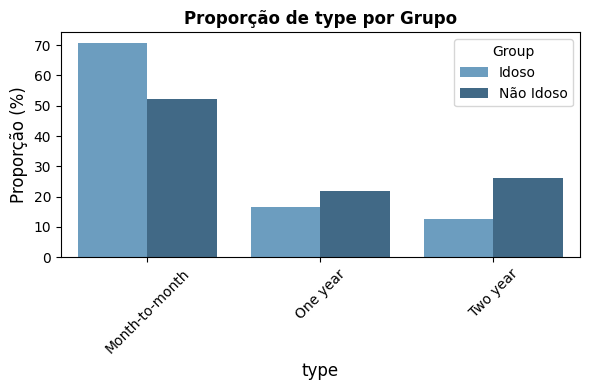

###############################################################################
  paperless_billing      Idoso  Não Idoso
0               Yes  76.707531  55.891341
1                No  23.292469  44.108659


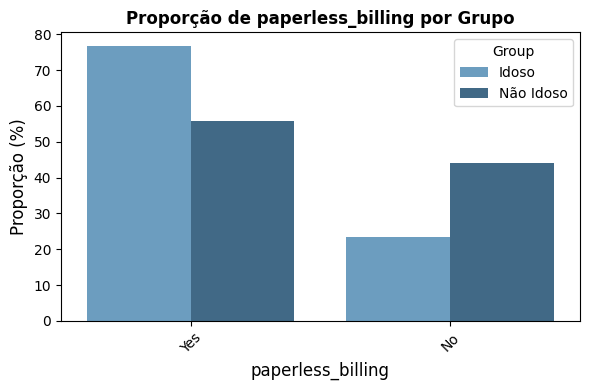

###############################################################################
              payment_method      Idoso  Não Idoso
0  Bank transfer (automatic)  20.402802  22.224109
1    Credit card (automatic)  19.352014  22.071307
2           Electronic check  52.014011  30.067912
3               Mailed check   8.231173  25.636672


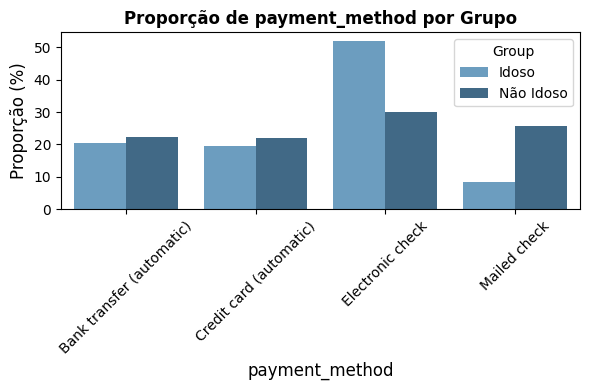

###############################################################################
  internet_service      Idoso  Não Idoso
0      Fiber optic  72.767075  38.455008
1              DSL  22.679510  36.621392
2               No   4.553415  24.923599


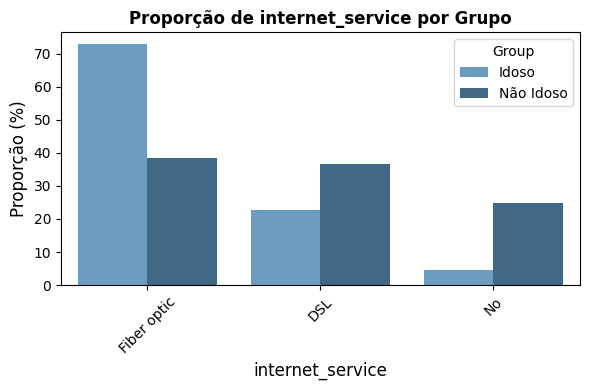

###############################################################################
  online_security     Idoso  Não Idoso
0              No  75.30648   70.57725
1             Yes  24.69352   29.42275


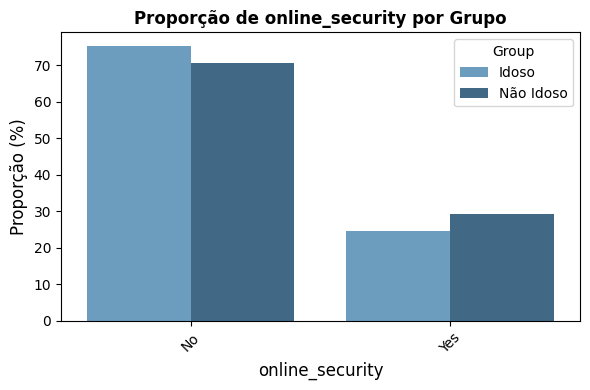

###############################################################################
  online_backup      Idoso  Não Idoso
0            No  58.318739  66.910017
1           Yes  41.681261  33.089983


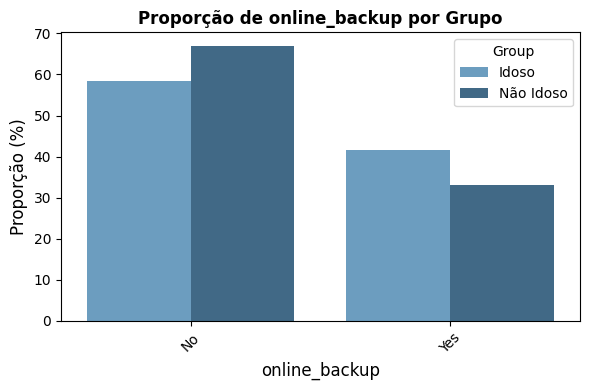

###############################################################################
  device_protection      Idoso  Não Idoso
0                No  59.194396  66.859083
1               Yes  40.805604  33.140917


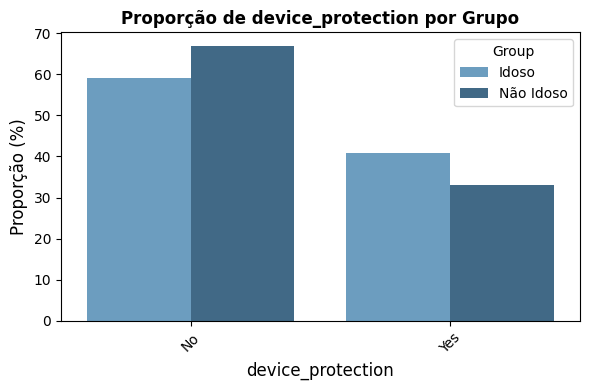

###############################################################################
  tech_support      Idoso  Não Idoso
0           No  77.232925  69.779287
1          Yes  22.767075  30.220713


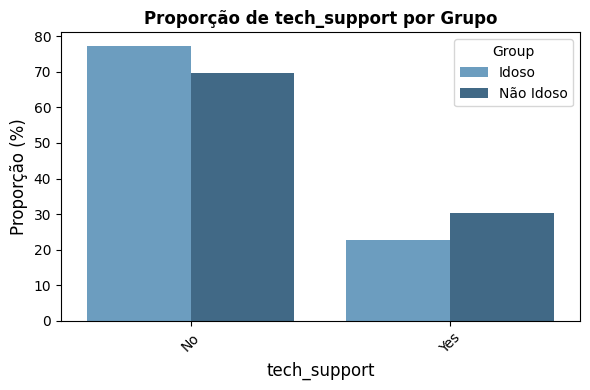

###############################################################################
  streaming_t_v      Idoso  Não Idoso
0            No  49.912434  63.820034
1           Yes  50.087566  36.179966


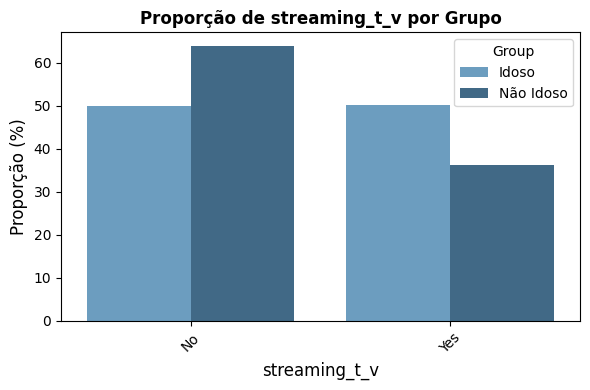

###############################################################################
  streaming_movies      Idoso  Não Idoso
0               No  47.898424  63.735144
1              Yes  52.101576  36.264856


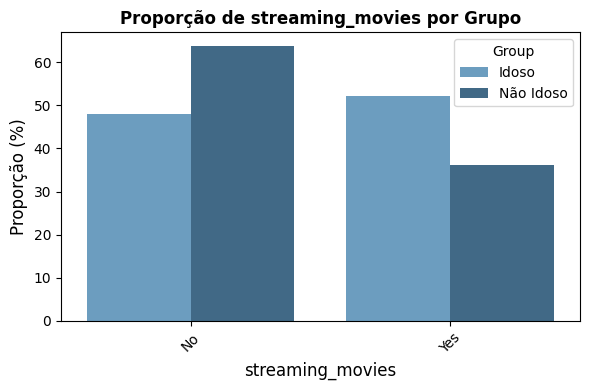

###############################################################################
   gender      Idoso  Não Idoso
0    Male  50.262697  50.509338
1  Female  49.737303  49.490662


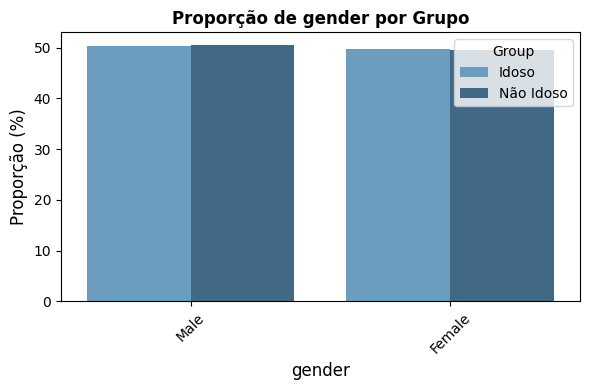

###############################################################################
   senior_citizen  Idoso  Não Idoso
0               0    NaN      100.0
1               1  100.0        NaN


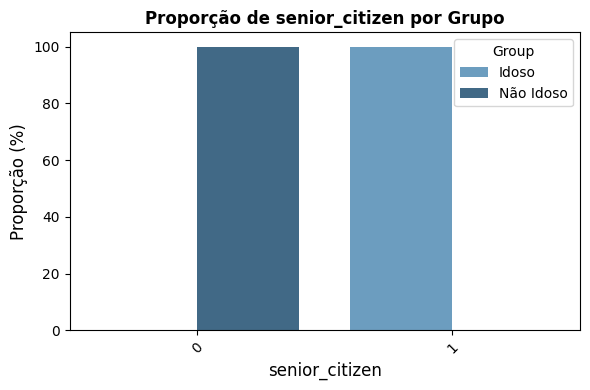

###############################################################################
  partner      Idoso  Não Idoso
0      No  49.824869  52.122241
1     Yes  50.175131  47.877759


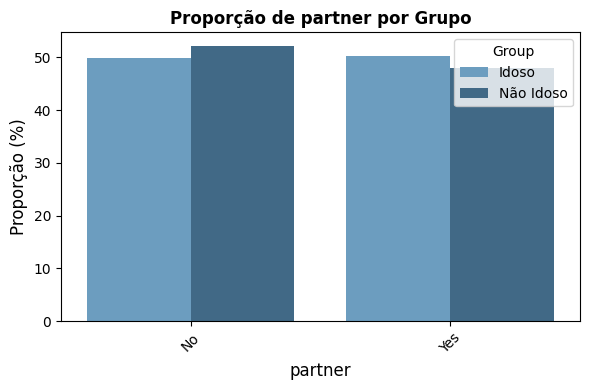

###############################################################################
  dependents      Idoso  Não Idoso
0         No  92.031524  65.908319
1        Yes   7.968476  34.091681


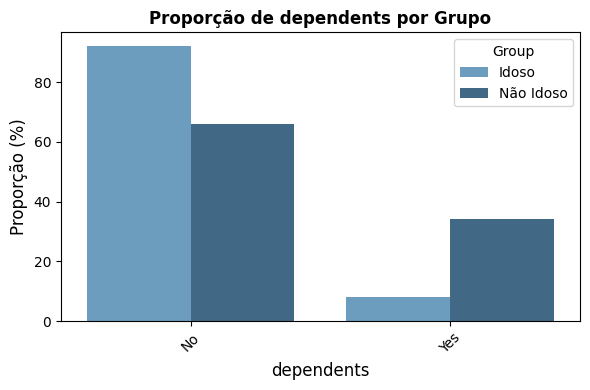

###############################################################################
  multiple_lines      Idoso  Não Idoso
0             No  41.768827  60.916808
1            Yes  58.231173  39.083192


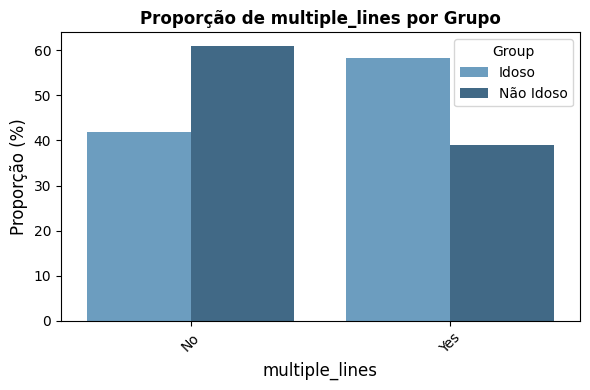

###############################################################################
  phone     Idoso  Não Idoso
0   Yes  90.89317  90.220713
1    No   9.10683   9.779287


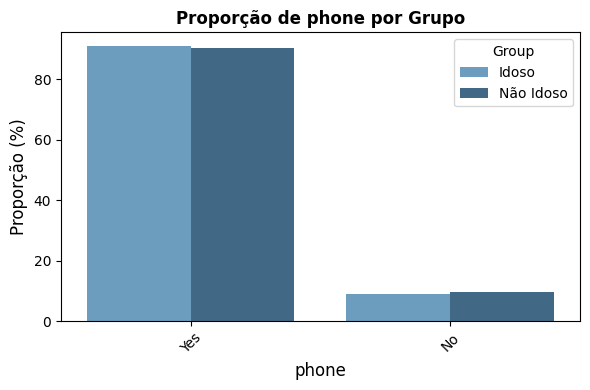

###############################################################################


In [45]:
for col in categorical:
    comparative(df_senior, df_no_senior, col, plot=True)

**Maiores diferenças entre os clientes idosos e os não-idosos:**

* Clientes idosos optam por contratos mês a mês em 70% dos casos, enquanto os clientes não-idosos optam por essa modalidade em 50% das vezes;
* Clientes idosos optam muito menos por contratos longos (2 anos) em relação aos clientes não-idosos;
* Clientes idosos surpreendentemente optam mais por não receber boletos em papel do que clientes não-idosos;
* Clientes idosos optam muito mais pelo método de pagamento 'Electronic check' do que os clientes não-idosos;
* Clientes idosos proporcionalmente utilizam quase o dobro de internet por fibra óptica do que os clientes não-idosos, que tem um equilíbrio entre fibra óptica e DSL;
* Clentes idosos contratam mais serviços de streaming de tv e filmes do que os clientes não idosos;
* Clientes idosos tem muito menos dependentes (8%) do que os clientes não-idosos (35%);
* Clientes idosos tem mais linhas múltiplas em comparação com os clientes não-idosos

Em resumo o grupo de clientes idosos tem uma taxa maior de churn do que clientes não idosos e optam em sua maioria pelas opções que mais refletem em churn, como contratos mês a mês, pagamento por cheque eletrônico, internet de fibra óptica, serviços de streaming de tv e filme, além de não terem dependentes e viverem mais sozinhos.

## Variáveis Numéricas

### Distribuições e Estatísticas Descritivas

In [46]:
def dist_numeric(df, col_name, plot=False):
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(df[col_name].describe(quantiles).T)

    if plot:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col_name], bins=30, kde=True)
        plt.xlabel(col_name, fontsize=12)
        plt.title(col_name, fontsize=12, weight='bold')
        plt.show(block=True)
        
        # Traçando um boxplot para análise de outliers
        plt.figure(figsize=(7, 4))
        sns.boxplot(x=df[col_name])
        plt.title(col_name, fontsize=12, weight='bold')
        plt.xlabel(col_name, fontsize=12)
        plt.show()

monthly_charges
count    7032.000000
mean       64.798208
std        30.085974
min        18.250000
5%         19.650000
10%        20.050000
20%        25.050000
30%        45.900000
40%        58.920000
50%        70.350000
60%        79.150000
70%        85.535000
80%        94.300000
90%       102.645000
95%       107.422500
99%       114.734500
max       118.750000
Name: monthly_charges, dtype: float64


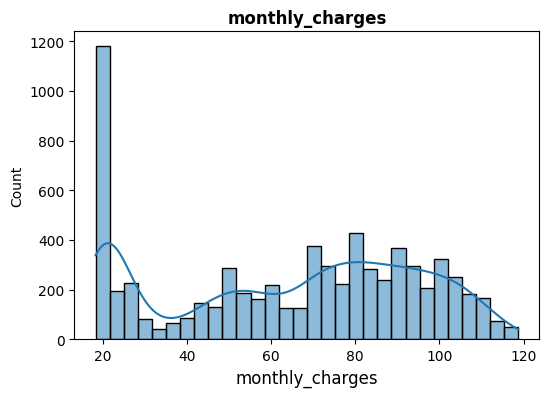

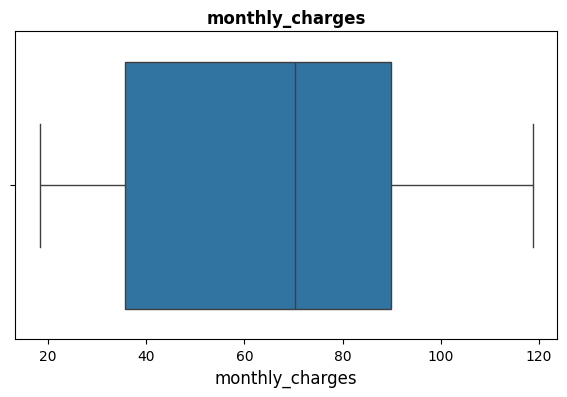

###################################################################
total_charges
count    7032.000000
mean     2283.300441
std      2266.771362
min        18.800000
5%         49.605000
10%        84.600000
20%       267.070000
30%       551.995000
40%       944.170000
50%      1397.475000
60%      2048.950000
70%      3141.130000
80%      4475.410000
90%      5976.640000
95%      6923.590000
99%      8039.883000
max      8684.800000
Name: total_charges, dtype: float64


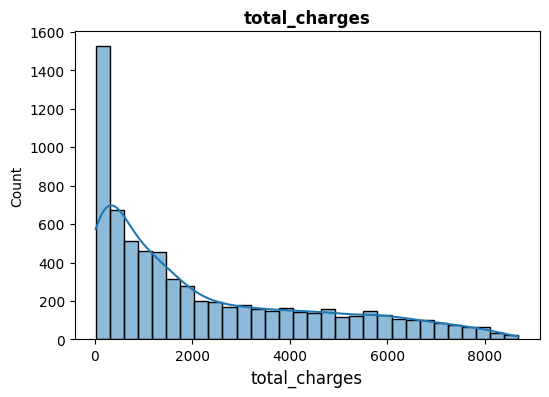

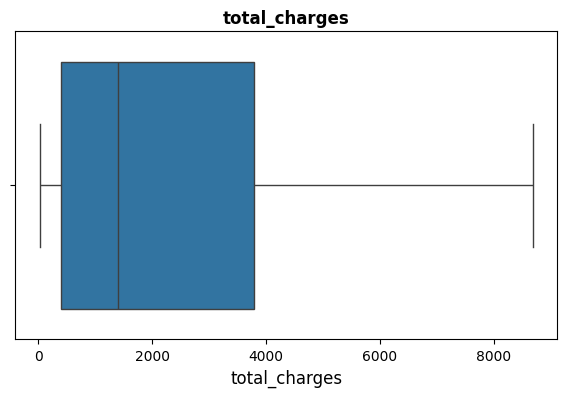

###################################################################


In [47]:
for col in numerical:
    print(col)
    dist_numeric(df_merged, col, plot=True)
    print('###################################################################')

### Comparação de médias entre clientes Churn e Não-Churn 

In [48]:
def churn_by_numerical(df, target, col_name):
    print(df.groupby(target).agg({col_name: "mean"}))

In [49]:
for col in numerical:
    churn_by_numerical(df_merged, "churn", col)
    print('##########################################')

       monthly_charges
churn                 
0            61.307408
1            74.441332
##########################################
       total_charges
churn               
0        2555.344141
1        1531.796094
##########################################


Os clientes que sofreram churn apresentaram uma média de despesa mensal maior em relação aos clientes que não sofreram churn.

Em compensação quando analisamos as despesas totais, esse fato se inverte. Isso nos mostra que as despesas totais não tem uma relação direta com o churn. Como elas são a somatória das despesas mensais, clientes mais fiéis tendem a ter uma despesa total maior devido ao tempo de contrato mais duradouro. Isso pode significar que clientes mais recentes tendem a sofrer mais churns do que clientes antigos. Vamos analisar os dados temporais em busca de mais informações.

## Análise de Dados Temporais

In [50]:
# Criando colunas com o mês e ano iniciais e finais

df_merged['begin_month'] = df_merged['begin_date'].dt.month
df_merged['begin_year'] = df_merged['begin_date'].dt.year

df_merged['end_month'] = df_merged['end_date'].dt.month
df_merged['end_year'] = df_merged['end_date'].dt.year

monthly = ['begin_month', 'end_month']
yearly = ['begin_year', 'end_year']

In [51]:
def dist_monthly(df, col_name, plot=False):
    
    if plot:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col_name], bins=12, kde=True)
        plt.xlabel(col_name)
        plt.title(col_name)
        plt.show(block=True)

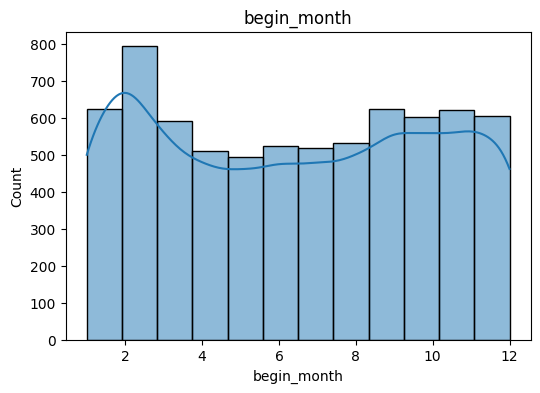

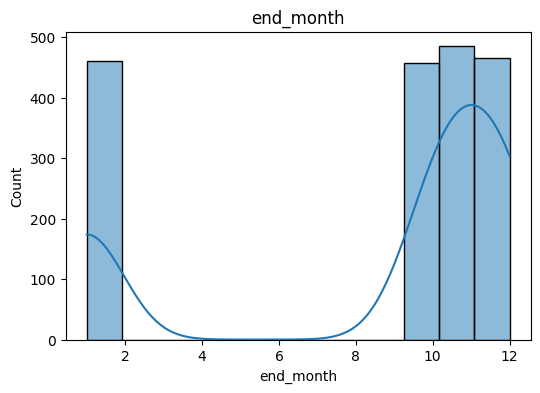

In [52]:
for col in monthly:
    dist_monthly(df_merged, col, plot=True)

A distribuição de inícios de contratos parece ser equilibrada, com destaque somente para o mês de fevereiro, que se destacou em relação aos demais meses.

Em relação aos cancelamentos de contrato, podemos observar que eles somente ocorreram nos meses de outubro, novembro, dezembro e janeiro, sendo que os demais meses não tiveram nenhum cancelamento de contrato.

In [53]:
df_temporal_churn = df_merged.groupby('end_date')[['customer_i_d']].count()
df_temporal_churn

customer_i_d
end_date                
2019-10-01           458
2019-11-01           485
2019-12-01           466
2020-01-01           460

Os churns ocorreram somente nos últimos 4 meses.

Analisando contratos ativos desde o ano de 2013 observamos que não haviam churns até o mês de outubro de 2019, quando iniciaram os cancelamentos de contratos.
Após esta data, os cancelamentos mantiveram o mesmo rítmo nos meses subsequentes.

É um fato curioso que a empresa não tenha sofrido churns por mais de 6 anos e agora eles tenham se tornado constantes. Isso indica que pode ter ocorrido alguma alteração significativa como:
* Entrada de uma nova concorrência direta no mercado a partir de outubro/2019;
* Alteração nos preços da empresa;
* Alteração no tipo de serviço ofertado (qualidade)

É interessante também analisar a duração dos contratos dos clientes que sofreram churn.

In [54]:
def dist_yearly(df, col_name, plot=False):
    
    if plot:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col_name], bins=8, kde=True)
        plt.xlabel(col_name)
        plt.title(col_name)
        plt.show(block=True)

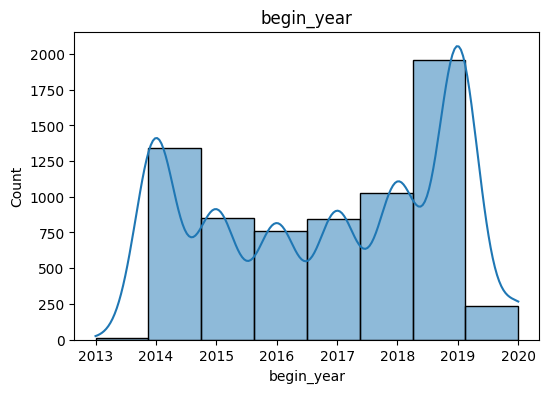

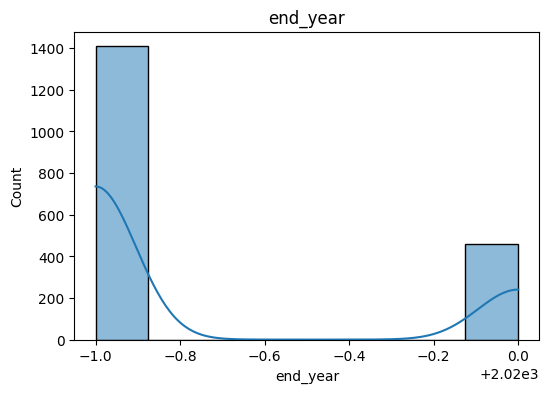

In [55]:
for col in yearly:
    dist_yearly(df_merged, col, plot=True)

Nota-se que apesar do aparecimento de churns a partir de outubro de 2019, a empresa teve um grande aumento de novos clientes neste ano, talvez alguma nova modalidade de serviço ou plano.

### Análise Temporal (tendência e sazonalidade)

#### Novos Clientes

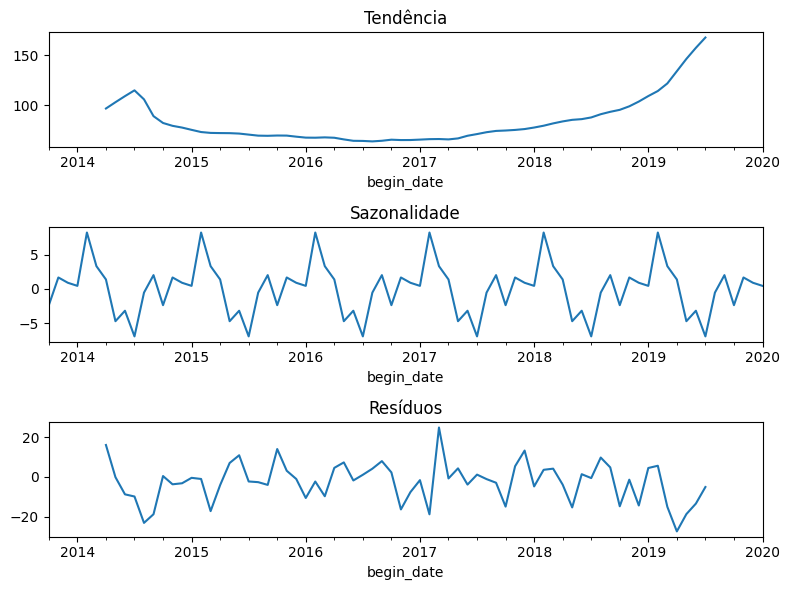

In [56]:
df_temporal_begin = df_merged.groupby('begin_date')[['customer_i_d']].count()
decomposed_begin = seasonal_decompose(df_temporal_begin)

# Plotando tendência
plt.figure(figsize=(8,6))
plt.subplot(311)
decomposed_begin.trend.plot(ax=plt.gca())
plt.title('Tendência')

# Plotando sazonalidade
plt.subplot(312)
decomposed_begin.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')

# Plotando resíduo
plt.subplot(313)
decomposed_begin.resid.plot(ax=plt.gca())
plt.title('Resíduos')

plt.tight_layout()

Os contratos começaram no final do ano de 2013, observa-se uma tendência de aumento em 2014 e logo uma tendência de queda a partir do segundo semestre do mesmo ano. Os novos contratos depois se mantiveram estáveis até a metade de 2017 quando iniciou-se uma tendência de alta que se manteve até meados de 2019.

Analisando-se a sazonalidade dos novos contratos, observamos picos no mês de fevereiro e vales no mês de julho

### Média de preços mensais

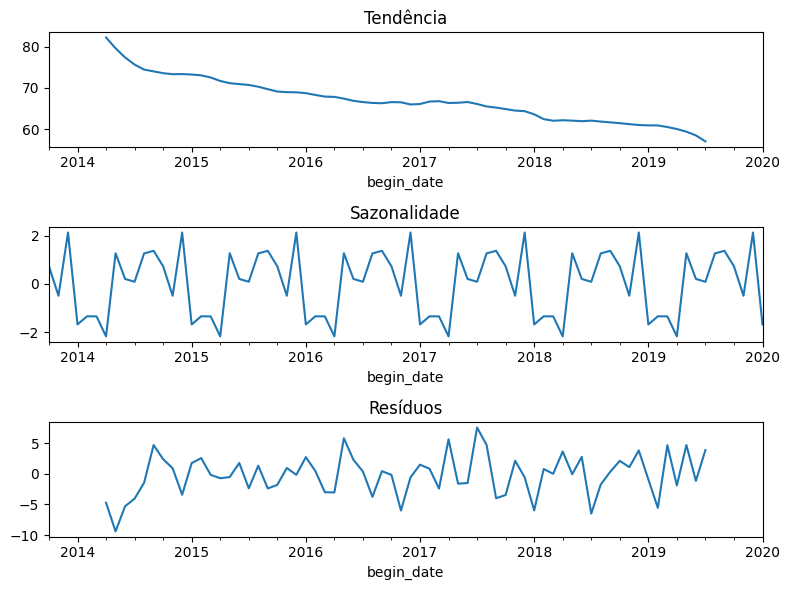

In [57]:
df_temporal_charge = df_merged.groupby('begin_date')[['monthly_charges']].mean()
decomposed_charges = seasonal_decompose(df_temporal_charge)

# Plotando tendência
plt.figure(figsize=(8,6))
plt.subplot(311)
decomposed_charges.trend.plot(ax=plt.gca())
plt.title('Tendência')

# Plotando sazonalidade
plt.subplot(312)
decomposed_charges.seasonal.plot(ax=plt.gca())
plt.title('Sazonalidade')

# Plotando resíduo
plt.subplot(313)
decomposed_charges.resid.plot(ax=plt.gca())
plt.title('Resíduos')

plt.tight_layout()

Podemos observar que houve uma tendência de queda em relação à média dos preços pagos pelos clientes desde o início das atividades (medido a partir de 2014)

Quanto à sazonalidade, observamos que há um aumento acentuado das médias de preços pagos pelos clientes nos meses de maio, agosto e dezembro (quando atinge seu pico), e quedas acentuadas nos meses de janeiro e novembro. 

### Análise temporal dados categóricos

In [58]:
def cat_temporal_analysis(df, col_name, date_col='begin_date'):
    # Criando séries temporais para cada tipo de contrato
    options = df[col_name].unique()

    for option in options:
        df_analysis = df[df[col_name] == option]

        # Agrupando por data de início e reamostrando mensalmente
        df_temporal = df_analysis.set_index(date_col).resample('ME')['customer_i_d'].count()

        # Verificando se há dados suficientes para decomposição
        if len(df_temporal) >= 24:
            decomposed = seasonal_decompose(df_temporal, period=12)  # Período de 12 meses para sazonalidade anual

            # Plotando Tendência
            plt.figure(figsize=(6, 4))
        
            plt.subplot(311)
            decomposed.trend.plot(ax=plt.gca())
            plt.title(f'Tendência {col_name} - {option}')

            plt.tight_layout()
            plt.show()

        else:
            print(f"Dados insuficientes para decomposição")
            
    print('##############################################################################')

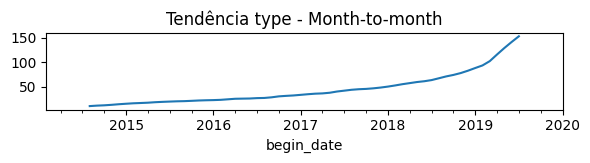

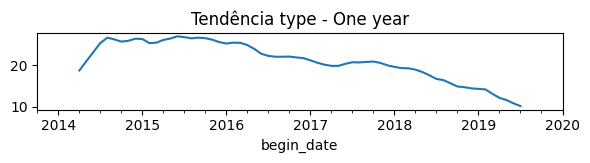

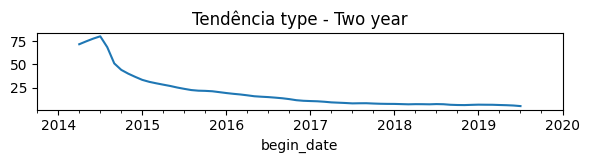

##############################################################################


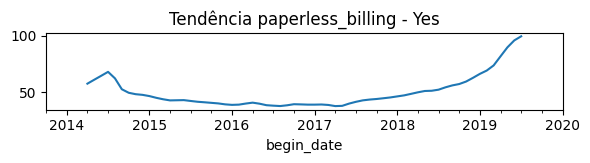

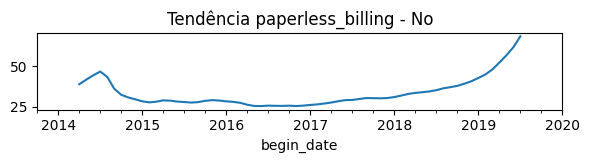

##############################################################################


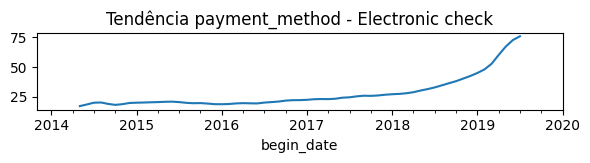

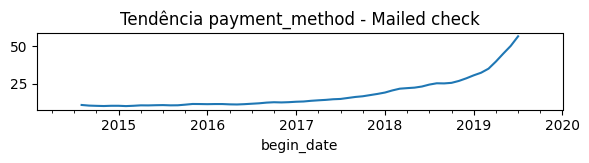

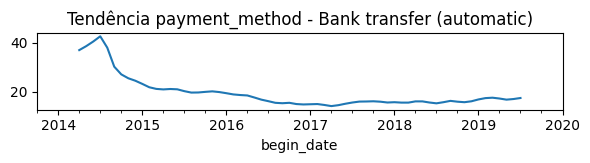

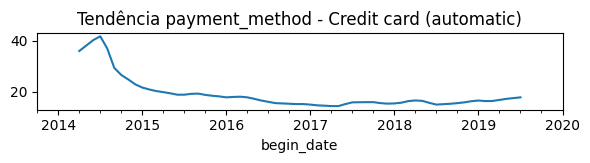

##############################################################################


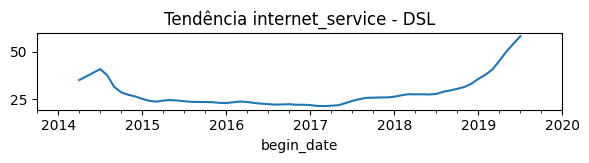

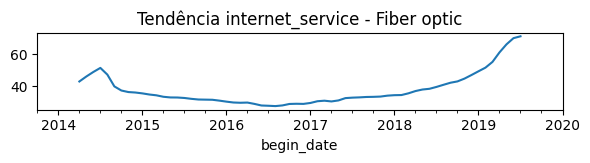

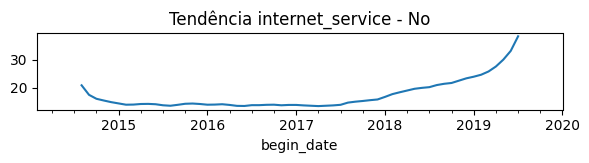

##############################################################################


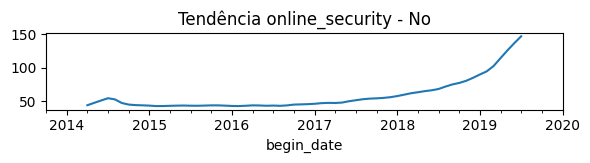

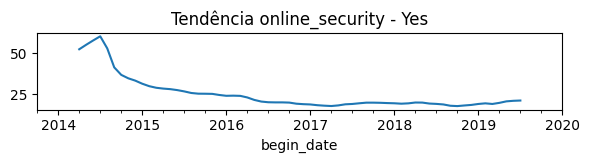

##############################################################################


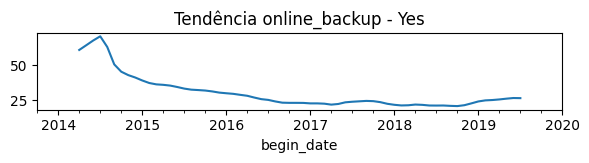

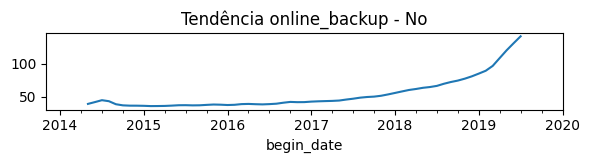

##############################################################################


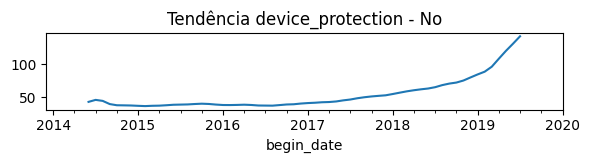

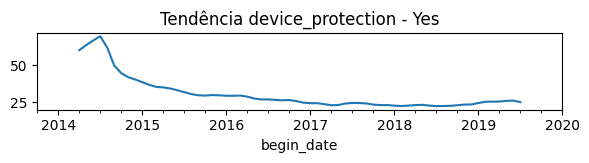

##############################################################################


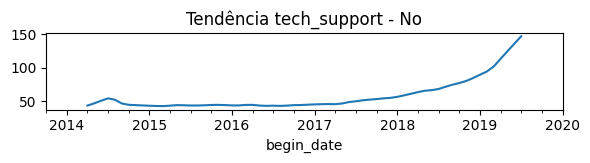

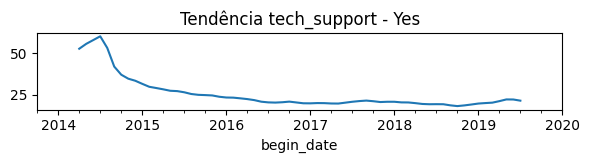

##############################################################################


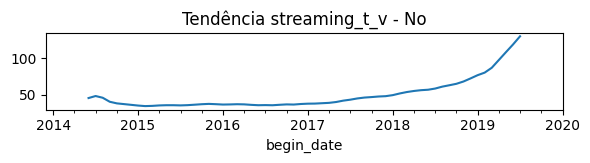

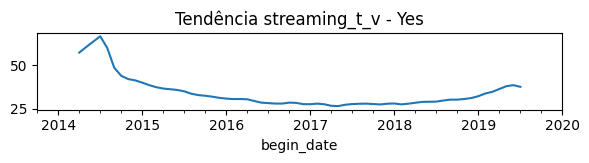

##############################################################################


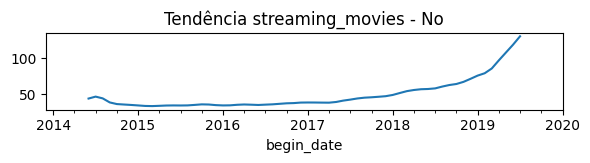

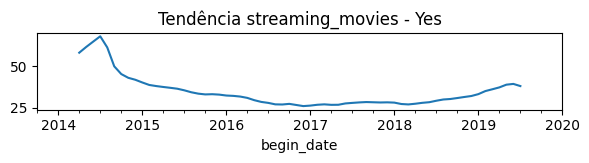

##############################################################################


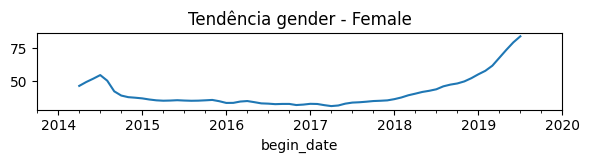

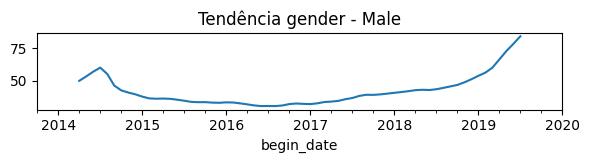

##############################################################################


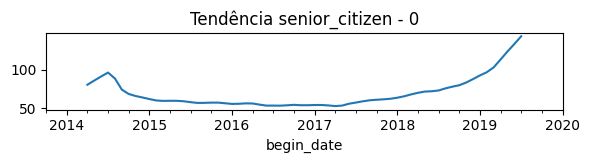

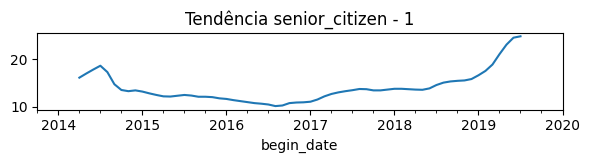

##############################################################################


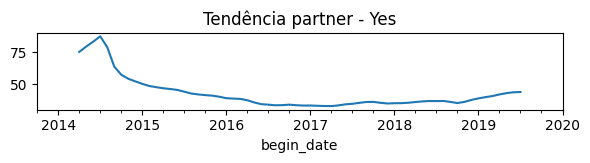

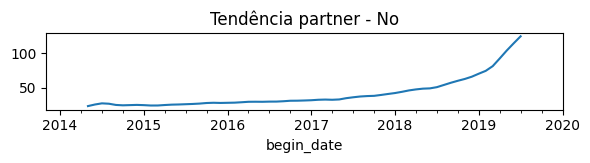

##############################################################################


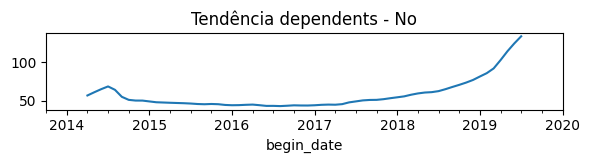

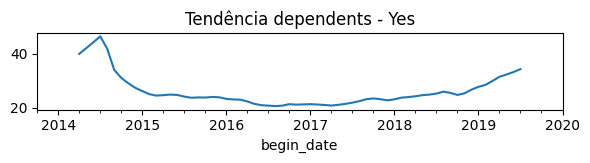

##############################################################################


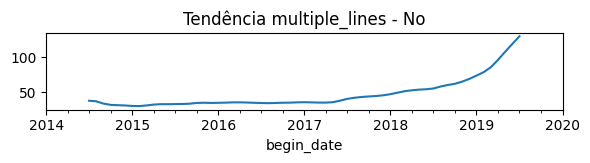

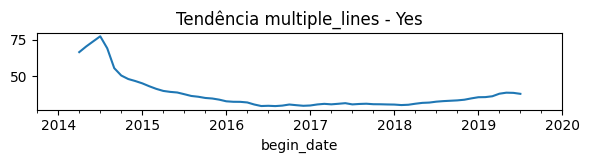

##############################################################################


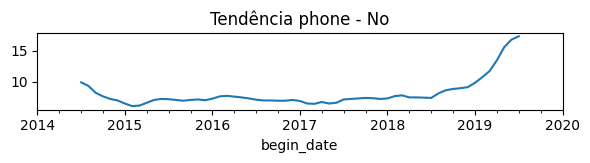

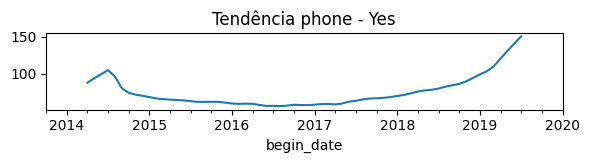

##############################################################################


In [59]:
for col in categorical:
    cat_temporal_analysis(df_merged, col)

* **Tipo de contrato:** podemos observar uma tendência de alta de clientes que optam por contratos na modalidade 'mês a mês'. Os clientes que optam pela modalidade de contrato de 1 ano tiveram uma forte alta no ano de 2014, quando a empresa ainda estava no início de suas atividades, mas depois se estabilizou e após a metade do ano de 2016 apresentou uma forte tendência de baixa, que se estende até a atualidade. Os clientes que optam por contratos mais longos, de 2 anos somente tiveram tendência de alta no início, em 2014, mas já a partir da metade de 2014 apresentou uma forte tendência de queda.  Com isso podemos perceber que cada vez mais a tendência é de que os clientes optem por contratos mais curtos, possibilitando o cancelamento do serviço a cada mês.

* **Métodos de pagamento:** é possível observar uma tendência dos clientes reduzirem a opção por pagamentos automáticos e preferirem cheques eletrônicos ou mesmo físicos para o pagamento de suas mensalidades.

* **Serviços extras:** analisando as tendências relacionadas aos serviçoes, extras, como 'online security', 'online backup', 'device protection, 'tech support', verificamos que não há uma tendência de alta nestas contratações. A grande maioria dos novos clientes opta pela não contratação desse tipo de serviços adicionais, o que pode ser observado comparando estas tendências com as tendências de não contratação, que tem acompanhado a tendência de novos contratos;

* **Serviços de streaming:** este tipo de serviço teve uma tendência de alta a partir do meio de 2018, mas já voltou a apresentar uma tendência de queda novamente a partir de 2019;

* **Parceiros e dependentes:** observa-se uma tendência muito mais acentuada de alta relativa aos clientes que não possuem parceiros e nem dependentes. Os clientes que possuem parceiros e dependentes também tem uma tendência de alta, porém, ela é muito mais leve do que a do primeiro grupo. 

# FEATURE ENGINEERING

Nesta etapa serão criadas colunas que podem auxiliar os nossos modelos a prever os churns, com base nas análises realizadas anteriormente

In [60]:
df_merged.head(3)

customer_i_d begin_date   end_date            type paperless_billing  \
0   7590-VHVEG 2020-01-01        NaT  Month-to-month               Yes   
1   5575-GNVDE 2017-04-01        NaT        One year                No   
2   3668-QPYBK 2019-10-01 2019-12-01  Month-to-month               Yes   

     payment_method  monthly_charges  total_charges internet_service  \
0  Electronic check            29.85          29.85              DSL   
1      Mailed check            56.95        1889.50              DSL   
2      Mailed check            53.85         108.15              DSL   

  online_security  ... senior_citizen partner dependents multiple_lines phone  \
0              No  ...              0     Yes         No             No    No   
1             Yes  ...              0      No         No             No   Yes   
2             Yes  ...              0      No         No             No   Yes   

  churn  begin_month begin_year end_month end_year  
0     0            1       2020       NaN      NaN  
1     0            4       2017       NaN      NaN  
2     1           10       2019      12.0   2019.0  

[3 rows x 26 columns]

## Coluna com a duração dos contratos em meses

In [61]:
df_merged['begin_date'].max()

Timestamp('2020-01-01 00:00:00')

In [62]:
# Criar uma coluna 'today' com a última data disponível no DataFrame
df_merged['today'] = pd.to_datetime('2020-01-01 00:00:00')

# Criar uma coluna com a duração do contrato em meses até a última data disponível
df_merged['duration_months'] = df_merged.apply(
    lambda row: (row['end_date'] - row['begin_date']) if pd.notna(row['end_date']) else (row['today'] - row['begin_date']), axis=1)

df_merged['duration_months'] = (df_merged['duration_months'].dt.days / 30.44).round()

## Coluna com a média de gasto mensal por cliente

In [63]:
df_merged['avg_charges'] = np.where(df_merged['duration_months'] < 1,df_merged['monthly_charges'],
                                    df_merged['total_charges'] / df_merged['duration_months'])

## Coluna da razão do preço atual pela média de preços do cliente

O objetivo desta coluna é verificar se houve um aumento de preço pago pelo cliente. 
* Se ratio > 1, o cliente teve aumento na tarifa;
* Se ratio < 1, o cliente teve redução na tarifa.

In [64]:
df_merged['ratio_charges'] = df_merged['monthly_charges'] / df_merged['avg_charges']

In [65]:
df_merged[['ratio_charges', 'avg_charges', 'monthly_charges', 'duration_months']].sample(3)

ratio_charges  avg_charges  monthly_charges  duration_months
5337       0.947111    52.792105            50.00             19.0
4483       0.946608    27.043939            25.60             66.0
257        0.967545   118.185714           114.35             49.0

In [66]:
df_ratio_pos = df_merged[df_merged['ratio_charges'] > 1]
df_ratio_neg = df_merged[df_merged['ratio_charges'] < 1]

print('taxa de churn de clientes que tiveram aumento de tarifa:', df_ratio_pos['churn'].mean())
print('taxa de churn de clientes que tiveram redução de tarifa:', df_ratio_neg['churn'].mean())

taxa de churn de clientes que tiveram aumento de tarifa: 0.469630557294928
taxa de churn de clientes que tiveram redução de tarifa: 0.15314380576883171


Não conseguimos analisar quando exatamente houveram aumentos ou ajustes de tarifas, pois não temos dados disponíveis mês a mês, temos somente a média de despesas e a despesa mensal atual. 

## Coluna com o número de serviços contratados por cliente

In [67]:
df_merged['total_services'] = (df_merged[['internet_service', 'online_security', 'online_backup',
                                          'device_protection', 'tech_support', 'streaming_t_v',
                                          'streaming_movies', 'multiple_lines', 'phone']]!= 'No').sum(axis=1)

In [68]:
# Checando se a contagem está correta
df_merged[['internet_service', 'online_security', 'online_backup',
           'device_protection', 'tech_support', 'streaming_t_v',
           'streaming_movies', 'multiple_lines', 'phone', 'total_services']].sample(5)

internet_service online_security online_backup device_protection  \
1811      Fiber optic              No            No               Yes   
6047              DSL             Yes            No                No   
2703              DSL              No            No                No   
5145               No              No            No                No   
2780              DSL             Yes           Yes               Yes   

     tech_support streaming_t_v streaming_movies multiple_lines phone  \
1811           No            No               No            Yes   Yes   
6047           No            No              Yes            Yes   Yes   
2703           No            No               No            Yes   Yes   
5145           No            No               No            Yes   Yes   
2780          Yes           Yes               No             No   Yes   

      total_services  
1811               4  
6047               5  
2703               3  
5145               2  
2780               7

In [69]:
# Média de churn por quantidade de serviços contratados
df_merged.groupby('total_services')['churn'].mean()

total_services
1    0.109524
2    0.310385
3    0.449173
4    0.364767
5    0.313789
6    0.256071
7    0.225519
8    0.124051
9    0.052885
Name: churn, dtype: float64

Clientes com 2 a 7 serviços tendem a ter mais churn. 

Clientes com 1 serviço somente (linha telefônica) tem tendência baixa de churn, assim como clientes que utilizam 8 ou 9 serviços.

## Coluna de preço médio por serviço contratado

In [70]:
df_merged['charges_per_services'] = df_merged['monthly_charges'] / df_merged['total_services']

## Coluna de faixa de preços por cliente

In [71]:
# Divisão dos preços em 5 faixas de tamanho aproximadamente igual

faixas = [0, 25, 45, 70, 95, 120]
labels = ['Very Low', 'Low', 'Medium', 'High', 'Very High']

df_merged['price_label'] = pd.cut(df_merged['monthly_charges'], bins=faixas, labels=labels)

In [72]:
df_merged[['price_label']].value_counts()

price_label
High           2286
Medium         1427
Very Low       1402
Very High      1295
Low             622
Name: count, dtype: int64

In [73]:
churn_by_price_label = df_merged.groupby('price_label', observed=False)['churn'].mean()
churn_by_price_label

price_label
Very Low     0.090585
Low          0.225080
Medium       0.234758
High         0.371391
Very High    0.322780
Name: churn, dtype: float64

## Coluna de categorias de cliente por tempo de contrato

* 1 a 6 meses: 'beginner' (0)
* 7 a 12 meses: 'newbie' (1)
* 13 a 18 meses: 'regular' (2)
* 19 a 24 meses: 'intermediate' (3)
* 25 a 36 meses: 'advanced' (4)
* Acima de 36 meses: 'expert' (5)

In [74]:
# Função para categorização dos clientes por tempo

def time_level(month):
    if month < 7:
        return 0
    elif month < 13:
        return 1
    elif month < 19:
        return 2
    elif month < 25:
        return 3
    elif month < 37:
        return 4
    else:
        return 5

In [75]:
df_merged['time_lvl'] = df_merged['duration_months'].apply(time_level)

In [76]:
df_merged.groupby('time_lvl')['churn'].mean()

time_lvl
0    0.505806
1    0.363506
2    0.333333
3    0.244770
4    0.217918
5    0.121315
Name: churn, dtype: float64

* Clientes que tem até 6 meses de contrato ativo, tem mais de 50% de churn.
* É possível observar uma tendência de queda do churn de acordo com o tempo de fidelidade do cliente, ou seja, quanto mais recente o cliente, maior a probabilidade de churn

## Coluna de tempo de contrato vs número de serviços

Os grupos foram divididos com base nas taxas de churn por número de serviço.   
Foi possível observar que clientes com 1 serviço tendem a ter menos churn, assim como clientes que tem 8 ou 9 serviços contratados

* 0 a 12 meses & 1  serviço: (0);
* 0 a 12 meses & 2 a 4 serviços: (1);
* 0 a 12 meses & 5 a 7 serviços: (2);
* 0 a 12 meses & 8 a 9 serviços: (3)
  
* 13 a 24 meses & 1 serviço: (4);
* 13 a 24 meses & 2 a 4 serviços: (5);
* 13 a 24 meses & 5 a 7 serviços: (6);
* 13 a 24 meses & 8 a 9 serviços: (7)
  
* Acima de 24 meses & 1 serviço: (8);
* Acima de 24 meses & 2 a 4 serviços: (9);
* Acima de 24 meses & 5 a 7 serviços: (10)
* Acima de 24 meses & 8 a 9 serviços: (11)

In [77]:
def time_service_level (row):
    time = row['time_lvl']
    services = row['total_services']
    
    if time < 2:
        if services < 2:
            return 0
        elif services < 5:
            return 1
        elif services < 8:
            return 2
        else:
            return 3
        
    if time < 4:
        if services < 2:
            return 4
        elif services < 5:
            return 5
        elif services < 8:
            return 6
        else:
            return 7
        
    if time >= 4:
        if services < 2:
            return 8
        elif services < 5:
            return 9
        elif services < 8:
            return 10
        else:
            return 11
        

In [78]:
df_merged['t_serv_lvl'] = df_merged.apply(time_service_level, axis=1)

In [79]:
df_merged.groupby('t_serv_lvl')['churn'].mean()

t_serv_lvl
0     0.220401
1     0.537234
2     0.547872
3     0.600000
4     0.043062
5     0.333333
6     0.393678
7     0.090909
8     0.015936
9     0.158068
10    0.185706
11    0.095400
Name: churn, dtype: float64

* Os grupos 1,2 e 3 são os que apresentam maior média de churn, passando dos 50% e se destacando dos demais grupos. Estes grupos se referem aos clientes que tem menos de 1 ano de contrato ativo e tem mais de 1 serviço contratado;   
  
* Os grupos 5 e 6 vem na sequência com médias acima de 30% de churn e se referem aos clientes que tem de 1 a 2 anos de contrato ativo e tem de 2 a 7 serviços contratados. 

## Coluna de clientes que vivem sozinhos

In [80]:
def lonely (row):
    partner = row['partner']
    dependents = row['dependents']
    
    if partner == 'No' and dependents == 'No':
        return 1
    else:
        return 0
    

In [81]:
df_merged['lonely'] = df_merged.apply(lonely, axis=1)

In [82]:
df_merged.groupby('lonely')['churn'].mean()

lonely
0    0.198827
1    0.342378
Name: churn, dtype: float64

## Coluna de idosos novatos

In [83]:
def newbie_senior (row):
    senior = row['senior_citizen']
    time_lvl = row['time_lvl']
    
    if senior == 1 and time_lvl < 3:
        return 1
    else:
        return 0

In [84]:
df_merged['newbie_senior'] = df_merged.apply(newbie_senior, axis=1)

In [85]:
df_merged.groupby('newbie_senior')['churn'].mean()

newbie_senior
0    0.242140
1    0.641827
Name: churn, dtype: float64

## Coluna de idosos que optam por contratos mês a mês

In [86]:
def mtm_senior (row):
    senior = row['senior_citizen']
    type = row['type']
    
    if senior == 1 and type == 'Month-to-month':
        return 1
    else:
        return 0

In [87]:
df_merged['mtm_senior'] = df_merged.apply(mtm_senior, axis=1)

In [88]:
df_merged.groupby('mtm_senior')['churn'].mean()

mtm_senior
0    0.229398
1    0.546468
Name: churn, dtype: float64

## Coluna de idosos solitários

In [89]:
def lonely_senior (row):
    senior = row['senior_citizen']
    lonely = row['lonely']
    
    if senior == 1 and lonely == 1:
        return 1
    else:
        return 0

In [90]:
df_merged['lonely_senior'] = df_merged.apply(lonely_senior, axis=1)

In [91]:
df_merged.groupby('lonely_senior')['churn'].mean()

lonely_senior
0    0.246175
1    0.491979
Name: churn, dtype: float64

## Coluna de clientes que optam por pagamento automático

In [92]:
def auto_pay (row):
    payment_method = row['payment_method']
    
    if payment_method == 'Bank transfer (automatic)' or payment_method == 'Credit card (automatic)':
        return 1
    else:
        return 0

In [93]:
df_merged['auto_pay'] = df_merged.apply(auto_pay, axis=1)

In [94]:
df_merged.groupby('auto_pay')['churn'].mean()

auto_pay
0    0.347443
1    0.159974
Name: churn, dtype: float64

## Coluna de alto risco

Criação de uma coluna com a somatória de todas as categorias que refletem em mais churns

In [95]:
def cat_risk (row):
    
    payment_method = row['payment_method']
    internet_service = row['internet_service']
    paperless_billing = row['paperless_billing']
    type = row['type']
    online_security = row['online_security']
    tech_support = row['tech_support']
    ratio_charges = row['ratio_charges']
    total_services = row['total_services']
    price_label = row['price_label']
    lonely = row['lonely']
    t_serv_lvl = row['t_serv_lvl']
    time_lvl = row['time_lvl']
    
    count = 0
    
    if payment_method=='Electronic check':
        count += 1
    if internet_service=='Fiber optic':
        count += 1
    if paperless_billing=='Yes':
        count += 1
    if type=='Month-to-month':
        count += 1
    if online_security=='No':
        count += 1
    if tech_support=='No':
        count += 1
    if ratio_charges > 1:
        count += 1
    if 2 < total_services < 7:
        count += 1
    if price_label == 'High' or price_label == 'Very_High':
        count += 1
    if lonely=='Yes':
        count += 1
    if 0 < t_serv_lvl < 4:
        count += 1
    if time_lvl==0:
        count += 1
    
    return count

In [96]:
df_merged['cat_risk'] = df_merged.apply(cat_risk, axis=1)

In [97]:
df_merged.groupby('cat_risk')['churn'].mean()

cat_risk
0     0.000000
1     0.026718
2     0.031429
3     0.055507
4     0.149533
5     0.228327
6     0.347553
7     0.473134
8     0.564663
9     0.742627
10    0.810924
11    1.000000
Name: churn, dtype: float64

Quanto mais categorias de risco o cliente atende, maior o seu risco de churn. 

## Seleção de colunas relevantes

Eliminação das colunas do tipo datetime e outras colunas que não interferem no churn, como gênero e id

In [98]:
df_merged = df_merged.drop(['customer_i_d',
                            'begin_date',
                            'end_date',
                            'gender',
                            'begin_month',
                            'begin_year',
                            'end_month',
                            'end_year',
                            'today',
                            ], axis=1)

## DataFrame após feature engineering

In [99]:
pd.set_option('display.max_columns', None)

df_merged.head(3)

type paperless_billing    payment_method  monthly_charges  \
0  Month-to-month               Yes  Electronic check            29.85   
1        One year                No      Mailed check            56.95   
2  Month-to-month               Yes      Mailed check            53.85   

   total_charges internet_service online_security online_backup  \
0          29.85              DSL              No           Yes   
1        1889.50              DSL             Yes            No   
2         108.15              DSL             Yes           Yes   

  device_protection tech_support streaming_t_v streaming_movies  \
0                No           No            No               No   
1               Yes           No            No               No   
2                No           No            No               No   

   senior_citizen partner dependents multiple_lines phone  churn  \
0               0     Yes         No             No    No      0   
1               0      No         No             No   Yes      0   
2               0      No         No             No   Yes      1   

   duration_months  avg_charges  ratio_charges  total_services  \
0              0.0    29.850000       1.000000               2   
1             33.0    57.257576       0.994628               4   
2              2.0    54.075000       0.995839               4   

   charges_per_services price_label  time_lvl  t_serv_lvl  lonely  \
0               14.9250         Low         0           1       0   
1               14.2375      Medium         4           9       1   
2               13.4625      Medium         0           1       1   

   newbie_senior  mtm_senior  lonely_senior  auto_pay  cat_risk  
0              0           0              0         0         7  
1              0           0              0         0         2  
2              0           0              0         0         6

## Ajuste de colunas ordinais

### Coluna Internet_Service

In [100]:
# Ajustando a coluna internet_service considerando que 'Fiber optic' é um upgrade em relação a 'DSL'
internet_dict = {'No': 0, 'DSL': 1, 'Fiber optic': 2}

df_merged['internet_service'] = df_merged['internet_service'].map(internet_dict)

### Coluna price_label

In [101]:
price_dict = {'Very Low' : 0, 'Low': 1, 'Medium': 2, 'High': 3, 'Very High': 4}

df_merged['price_label'] = df_merged['price_label'].map(price_dict)

In [102]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   type                  7032 non-null   object  
 1   paperless_billing     7032 non-null   object  
 2   payment_method        7032 non-null   object  
 3   monthly_charges       7032 non-null   float64 
 4   total_charges         7032 non-null   float64 
 5   internet_service      7032 non-null   int64   
 6   online_security       7032 non-null   object  
 7   online_backup         7032 non-null   object  
 8   device_protection     7032 non-null   object  
 9   tech_support          7032 non-null   object  
 10  streaming_t_v         7032 non-null   object  
 11  streaming_movies      7032 non-null   object  
 12  senior_citizen        7032 non-null   int64   
 13  partner               7032 non-null   object  
 14  dependents            7032 non-null   object  
 15  multiple_

## Divisão dos dados

In [103]:
# Definindo as colunas que serão tratadas como características e objetivo
features = df_merged.drop('churn', axis=1)
target = df_merged['churn']

# Divisão dos dados em conjunto de treino e teste. 
features_train, features_test, target_train, target_test = train_test_split(features, target, train_size=0.8, random_state = 12345)

print(features_train.shape)
print(target_train.shape)
print(features_test.shape)
print(target_test.shape)

(5625, 31)
(5625,)
(1407, 31)
(1407,)


In [104]:
# Checar as proporções de churn nos conjuntos de treino e teste
train_proportion = target_train.value_counts(normalize=True)
test_proportion = target_test.value_counts(normalize=True)

print("Proporção de churn no conjunto de TREINO:")
print(train_proportion)
print()
print("Proporção de churn no conjunto de TESTE:")
print(test_proportion)

Proporção de churn no conjunto de TREINO:
churn
0    0.735822
1    0.264178
Name: proportion, dtype: float64

Proporção de churn no conjunto de TESTE:
churn
0    0.72779
1    0.27221
Name: proportion, dtype: float64


# CLUSTERIZAÇÃO

## Seleção de Variáveis para Clusterização

Nesta etapa serão removidas as colunas que não contribuem consideravelmente para a clusterização, ou seja, serão removidas as variáveis que tem pouca contribuição.  
Esta avaliação foi realizada após a tranformação PCA, com base na contribuição das variáveis originais para os primeiros componentes(PCA). O valor considerado é o valor absoluto (sem considerar sinal negativo).

OBS. O resultado da primeira iteração com todas as variáveis foi impresso em markdown abaixo devido à necessidade de realizar a transformação inversa dos dados posteriormente para plotagem dos gráficos dos clusters e, como algumas colunas são removidas durante o processo, o Encoder não permite realizar a transformação inversa. Abaixo terá novamente uma transformação PCA para visualização dos valores de contribuição das features que foram selecionadas como as mais importantes.

'Relevância' dos Componentes: [0.61500274 0.18483643 0.05733761 0.02839799 0.02182043 0.01826092
 0.01301156 0.00975598 0.00636186 0.00579313]


Contribuição de cada variável para o primeiro componente:

type                    0.099588  
paperless_billing       0.001428  
payment_method         -0.079513  
monthly_charges         0.070666  
total_charges           0.163013  
internet_service        0.018769  
online_security         0.036261  
online_backup           0.039657  
device_protection       0.042598  
tech_support            0.038781  
streaming_t_v           0.035617  
streaming_movies        0.035251  
senior_citizen          0.002468  
partner                 0.035654  
dependents              0.014206  
multiple_lines          0.035551  
duration_months         0.182909  
avg_charges             0.054347  
ratio_charges           0.062010  
total_services          0.120540  
charges_per_services   -0.104636  
price_label             0.088654  
time_lvl                0.397718  
t_serv_lvl              0.790649  
lonely                 -0.032865  
newbie_senior          -0.013312  
mtm_senior             -0.007351  
lonely_senior          -0.004032  
auto_pay                0.039352  
cat_risk               -0.283909  
Name: 0, dtype: float64"""  

Os dois primeiros componentes correspondem à 70% da relevância (0.61500274 + 0.18483643).

In [105]:
drop_list = ['type', 'paperless_billing', 'payment_method', 'online_security', 'online_backup',
'device_protection', 'tech_support', 'streaming_t_v', 'streaming_movies', 'senior_citizen', 'partner', 'dependents', 'multiple_lines',
'ratio_charges', 'charges_per_services', 'lonely',
'newbie_senior', 'mtm_senior', 'lonely_senior', 'auto_pay', 'internet_service', 'monthly_charges', 'avg_charges', 'price_label', 'phone']

# Criando um conjunto de features para ser usado na clusterização
features_train_cluster = features_train .drop(drop_list, axis=1)

## Transformação do conjunto de treinamento para clusterização

In [106]:
# Definição de colunas numéricas e categóricas
numerical = ['duration_months',  'total_services', 'total_charges']
categorical = ['t_serv_lvl', 'time_lvl',  'cat_risk']

In [107]:
# Codificação das colunas categóricas usando
cluster_encoder = OrdinalEncoder()
features_train_cluster.loc[:, categorical] = cluster_encoder.fit_transform(features_train_cluster[categorical])

In [108]:
# Padronização das colunas numéricas
cluster_scaler = StandardScaler()

features_train_cluster[numerical] = features_train_cluster[numerical].astype(float)
features_train_cluster.loc[:, numerical] = cluster_scaler.fit_transform(features_train_cluster[numerical])

In [109]:
# Aplicação de PCA para entender a importância de cada variável
pca = PCA(n_components=6)
pca.fit(features_train_cluster)

# Importância de cada componente (variância explicada)
print('Componentes:', pca.explained_variance_ratio_)

print()
# Contribuição das variáveis originais para o primeiro componente
print(pd.DataFrame(pca.components_, columns=features_train_cluster.columns).iloc[0])

Componentes: [0.805849   0.14740367 0.02984753 0.01204123 0.00307562 0.00178295]

total_charges      0.163602
duration_months    0.188926
total_services     0.113823
time_lvl           0.413934
t_serv_lvl         0.815972
cat_risk          -0.295694
Name: 0, dtype: float64


Agora, os 2 primeiros componentes correspondem 95% de relevância (0.80697407 + 0.14582797)

## Modelo KMeans

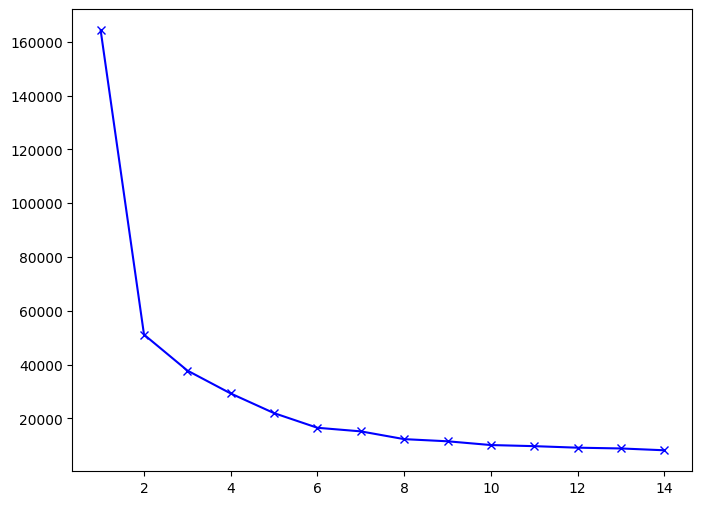

In [110]:
# Plot do gráfico para utilização do método do cotovelo para determinação do número de clusters
distortion = []
K = range(1,15)

for k in K:
    model_kmeans = KMeans(n_clusters=k, random_state=12345)
    model_kmeans.fit(features_train_cluster)
    distortion.append(model_kmeans.inertia_)


plt.figure (figsize=(8,6))
plt.plot(K, distortion, 'bx-')

plt.show()

De acordo com o gráfico, o platô se apresenta no índice 6. Portanto, este será o número de clusters selecionado

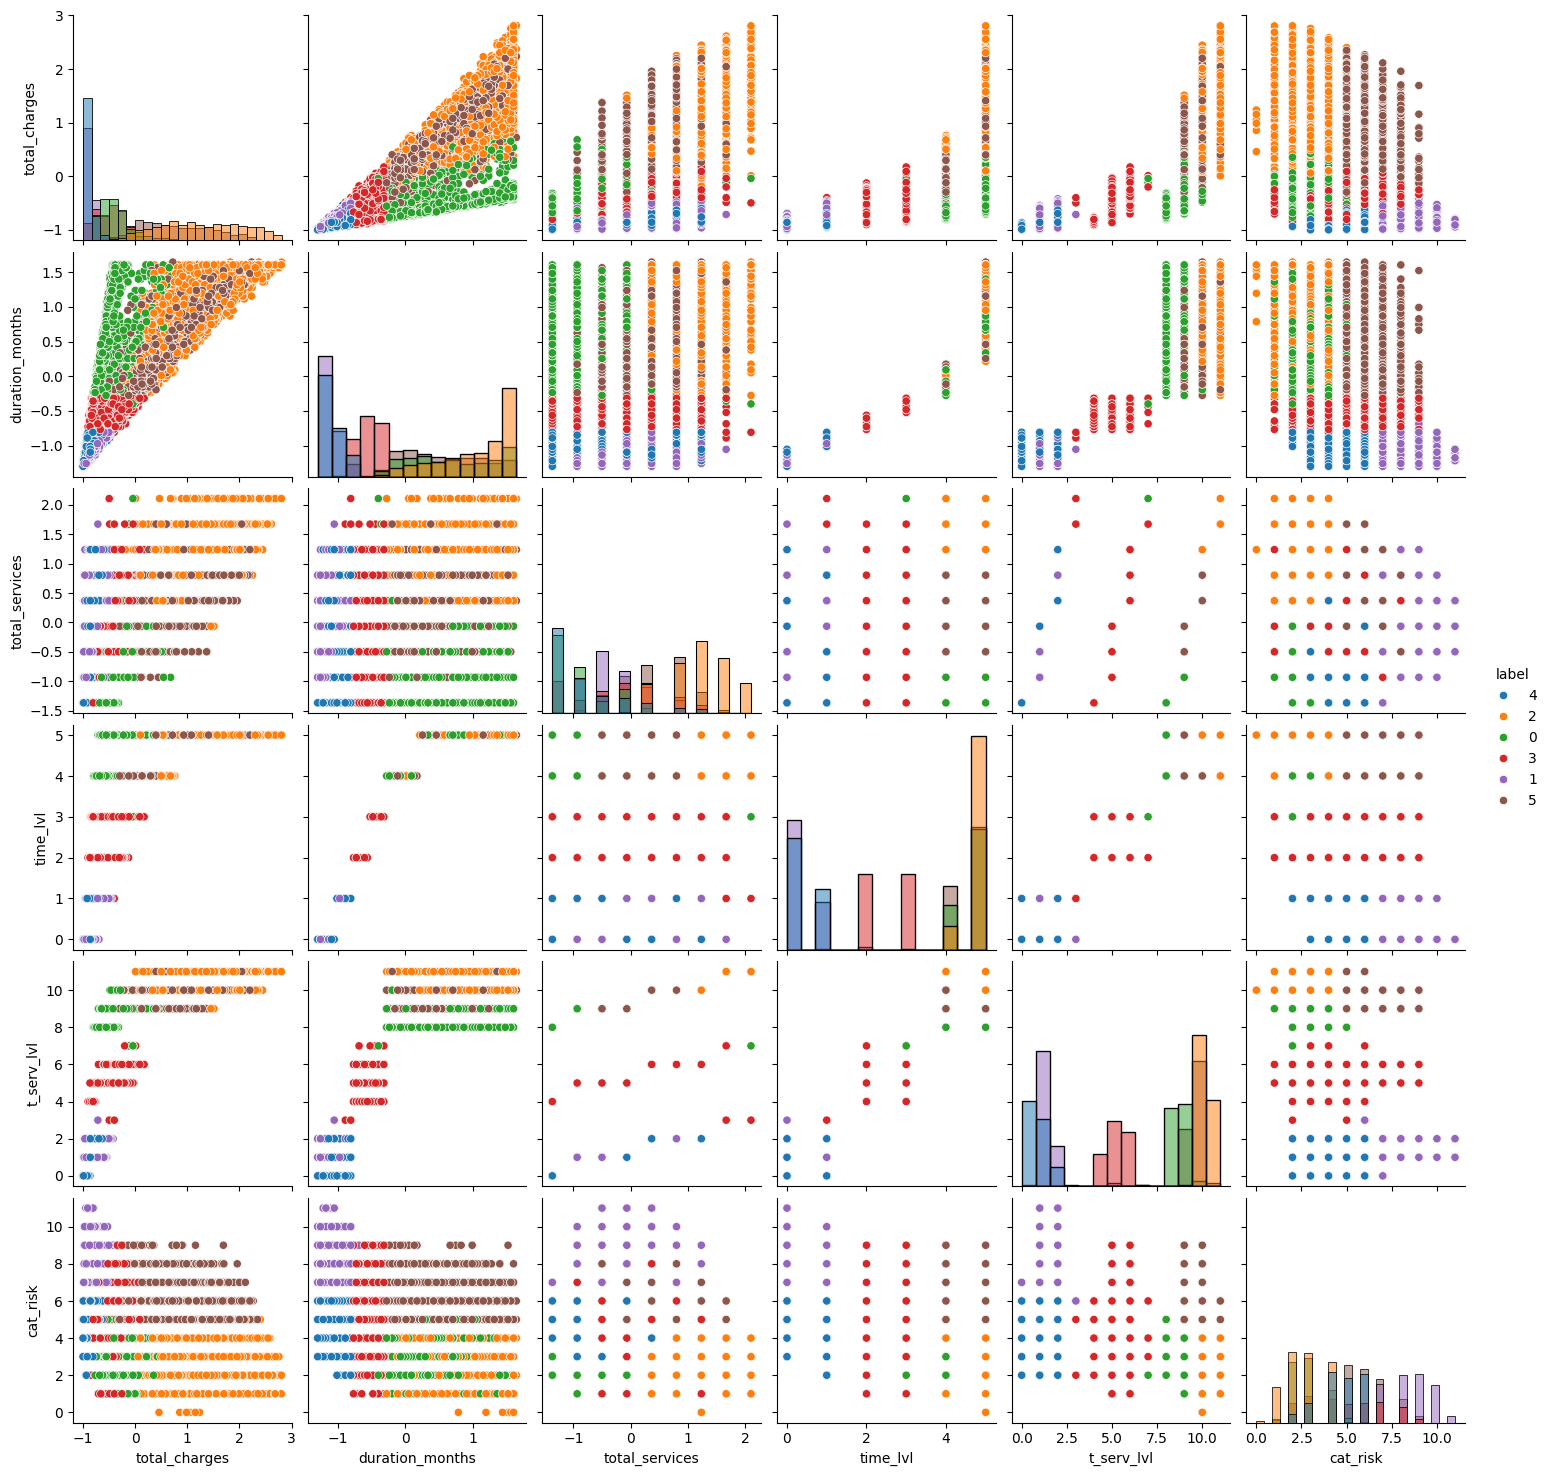

In [111]:
# Definição e treinamento do modelo Kmeans
model_kmeans = KMeans(n_clusters=6, random_state=12345)
model_kmeans.fit(features_train_cluster)

# Pairplot
centroids = pd.DataFrame(model_kmeans.cluster_centers_, columns = features_train_cluster.columns)
features_train_cluster['label'] = model_kmeans.labels_.astype('str')

data_all = pd.concat([features_train_cluster, centroids], ignore_index=True)
pairgrid = sns.pairplot(features_train_cluster, hue='label', diag_kind='hist', vars=features_train_cluster.columns[:-1])

### Visualização dos clusters

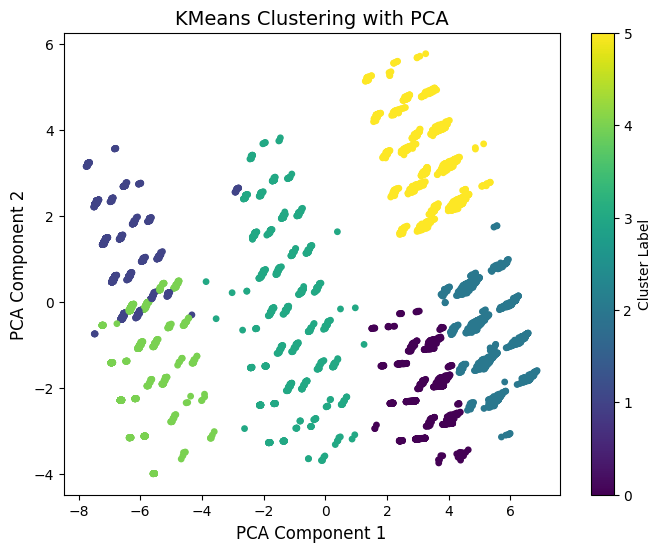

In [112]:
# Transformação PCA para visualização dos clusters em 2D
pca = PCA(n_components=2)
pca_components = pca.fit_transform(features_train_cluster)

plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=model_kmeans.labels_, cmap='viridis', s=15)
plt.title('KMeans Clustering with PCA', fontsize=14)
plt.xlabel('PCA Component 1', fontsize=12)
plt.ylabel('PCA Component 2', fontsize=12)
plt.colorbar(label='Cluster Label')
plt.show()

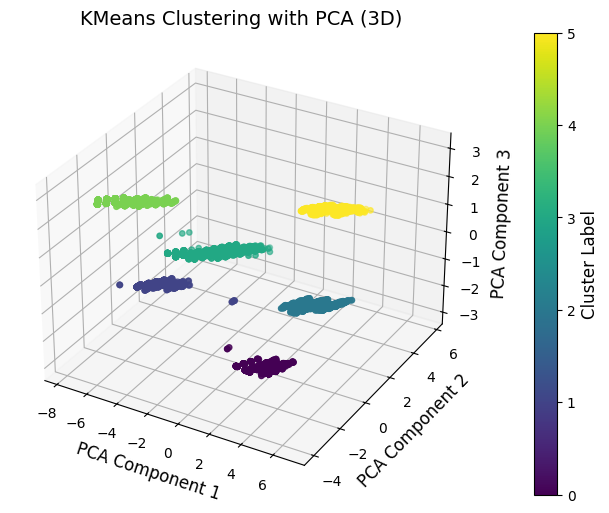

In [113]:
# Transformação PCA para visualização dos clusters em 3D
pca = PCA(n_components=3)
pca_components = pca.fit_transform(features_train_cluster)

# Criar a figura e o eixo 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(
    pca_components[:, 0], 
    pca_components[:, 1], 
    pca_components[:, 2], 
    c=model_kmeans.labels_, 
    cmap='viridis', 
    s=15)

# Títulos e rótulos
ax.set_title('KMeans Clustering with PCA (3D)', fontsize=14)
ax.set_xlabel('PCA Component 1', fontsize=12)
ax.set_ylabel('PCA Component 2', fontsize=12)
ax.set_zlabel('PCA Component 3', fontsize=12)

# Barra de cores para os rótulos
cbar = fig.colorbar(sc, ax=ax, pad=0.1)
cbar.set_label('Cluster Label', fontsize=12)

plt.show()

### Análise de churn por cluster

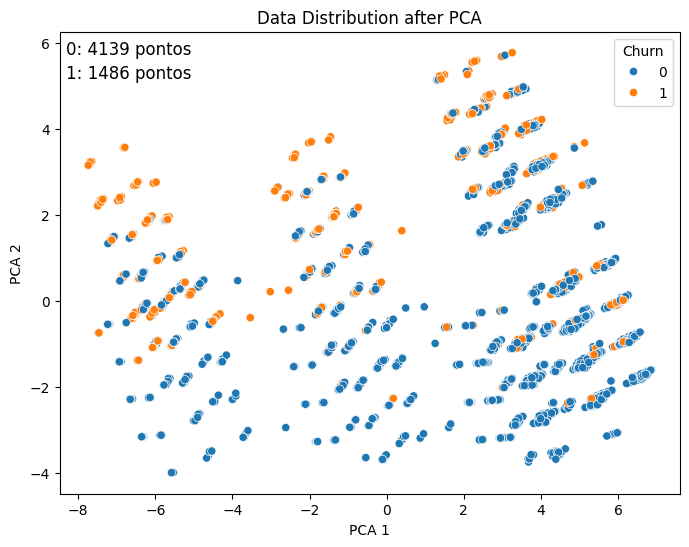

In [114]:
# Reduzir para 2 componentes principais
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_train_cluster)

# Plotar os dados usando as duas primeiras componentes principais
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=target_train)
plt.title('Data Distribution after PCA')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Churn')

# Contar o número de pontos de cada categoria (0 e 1)
churn_counts = target_train.value_counts()

# Adicionar o número de pontos de cada categoria no gráfico
for i, (label, count) in enumerate(churn_counts.items()):
    ax.text(
        0.01,
        0.95 - i * 0.05,
        f'{label}: {count} pontos',
        transform=ax.transAxes,
        fontsize=12,
        color='black')

plt.show()


In [115]:
features_cluster = features_train_cluster.reset_index()
target_cluster = target_train.reset_index()
df_cluster = features_cluster.merge(target_cluster, on='index')
df_cluster = df_cluster.drop('index', axis=1)

In [116]:
# Estatísticas descritivas de churn por cluster:
cluster_churn = df_cluster.groupby('label')['churn'].describe()
cluster_churn.sort_values('mean', ascending=False)

count      mean       std  min  25%  50%  75%  max
label                                                     
1       923.0  0.684724  0.464878  0.0  0.0  1.0  1.0  1.0
5       957.0  0.317659  0.465810  0.0  0.0  0.0  1.0  1.0
3       784.0  0.261480  0.439721  0.0  0.0  0.0  1.0  1.0
4       885.0  0.242938  0.429100  0.0  0.0  0.0  0.0  1.0
2      1224.0  0.084967  0.278947  0.0  0.0  0.0  0.0  1.0
0       852.0  0.030516  0.172104  0.0  0.0  0.0  0.0  1.0

* Cluster 1 apresenta 68% de churn, um percentual realmente elevado;  
  
* Os Clusters 5 e 3,  apresentam 32 e 26% de churn respectivamente, o que também são números muito elevados e acima da média;

* O Cluster 4, vem na sequência com 24%, o que ainda é considerável;

* Finalmente, os Clusters 2 e 0 apresentam somente 8% e 3% de probabilidade de churn.

In [117]:
# Revertendo a transformação para facilitar interpretação dos gráficos
df_cluster[numerical] = cluster_scaler.inverse_transform(df_cluster[numerical])
df_cluster[categorical] = cluster_encoder.inverse_transform(df_cluster[categorical])

In [118]:
def cluster_graph_cat(col_name):
    
    df_grouped = df_cluster.groupby(['label', col_name]).size().unstack().fillna(0)

    # Criar a figura e os eixos, ajustando a largura conforme o número de categorias
    num_categories = len(df_grouped.columns)
    fig, ax = plt.subplots(figsize=(14 + num_categories, 4))

    # Variável para armazenar a posição de cada grupo de barras
    bar_width = 0.8 / num_categories
    positions = np.arange(len(df_grouped))

    for i, option in enumerate(df_grouped.columns):
        ax.bar(
            positions + i * bar_width,
            df_grouped[option],
            width=bar_width,
            label=f'{option}')

    # Ajustar os rótulos do eixo x para serem centralizados em relação aos grupos de barras
    ax.set_xticks(positions + bar_width * (num_categories / 2))
    ax.set_xticklabels(df_grouped.index, rotation=45, ha='right')

    ax.set_title(f'Análise de {col_name} por Cluster', fontsize=16, weight='bold')
    ax.set_xlabel('Cluster', fontsize=12, weight='bold')
    ax.set_ylabel('Count', fontsize=12, weight='bold')

    ax.legend(title=col_name, title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()


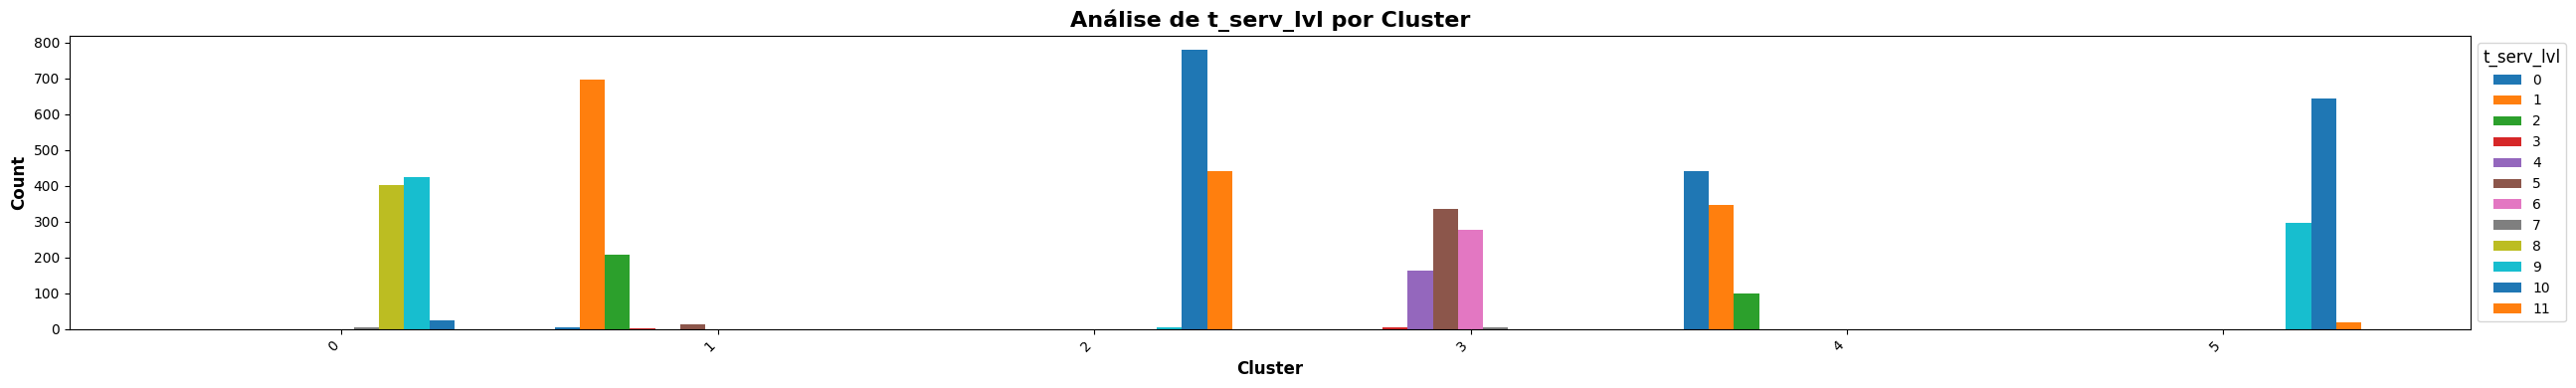

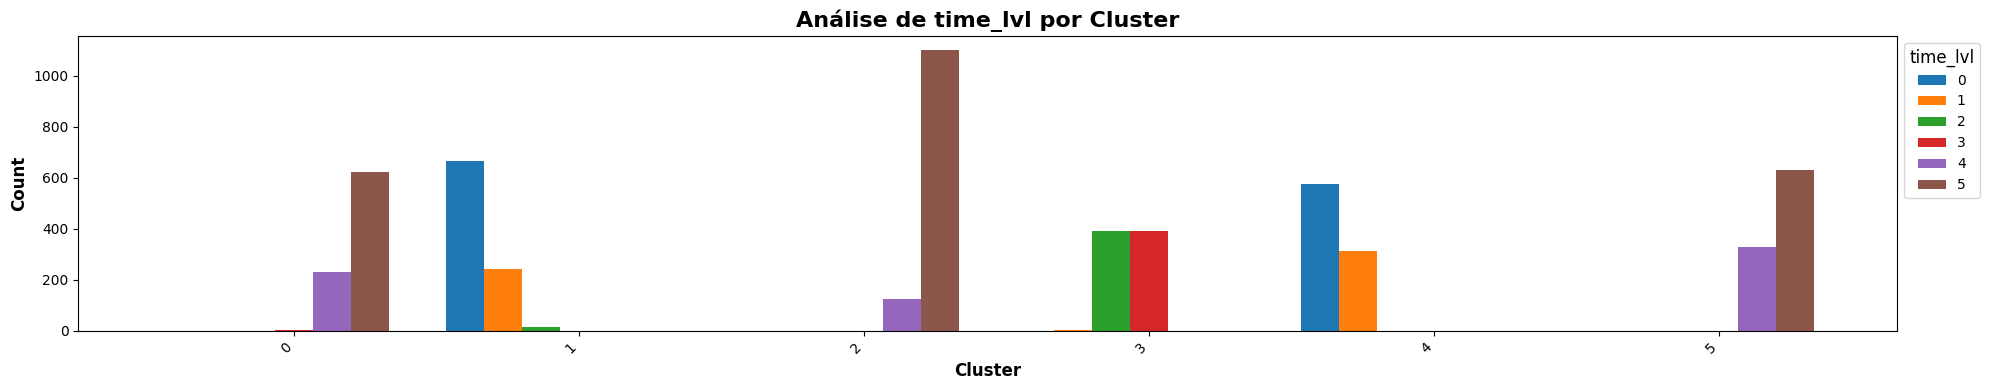

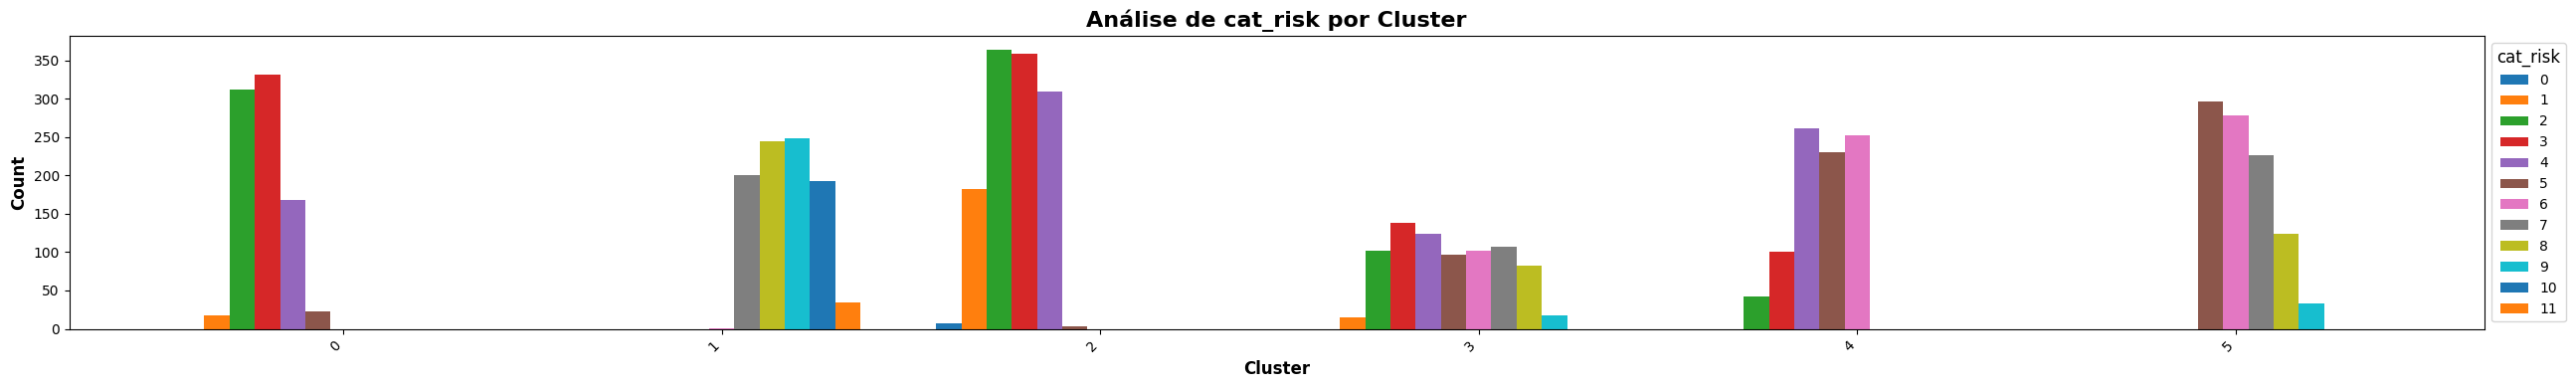

In [119]:
for col_name in features_train_cluster.loc[:, categorical]:
    cluster_graph_cat(col_name)

In [120]:
def cluster_graph_num(col_name):
    
    df_grouped_numerical = df_cluster.groupby('label')[col_name].mean()

    fig, ax = plt.subplots(figsize=(8, 4))

    bar_width = 0.4
    positions = np.arange(len(df_grouped_numerical))  # Uma posição para cada cluster

    ax.bar(
        positions,
        df_grouped_numerical,
        width=bar_width,
        label=col_name,
        color='dodgerblue')

    ax.set_xticks(positions)
    ax.set_xticklabels(df_grouped_numerical.index, rotation=45, ha='right')

    ax.set_title(f'Média de {col_name} por Cluster', fontsize=16, weight='bold')
    ax.set_xlabel('Cluster', fontsize=12, weight='bold')
    ax.set_ylabel('Média', fontsize=12, weight='bold')
    
    ax.grid(True, which='both', linestyle='--', linewidth=1, axis='y')
    
    plt.tight_layout()
    plt.show()


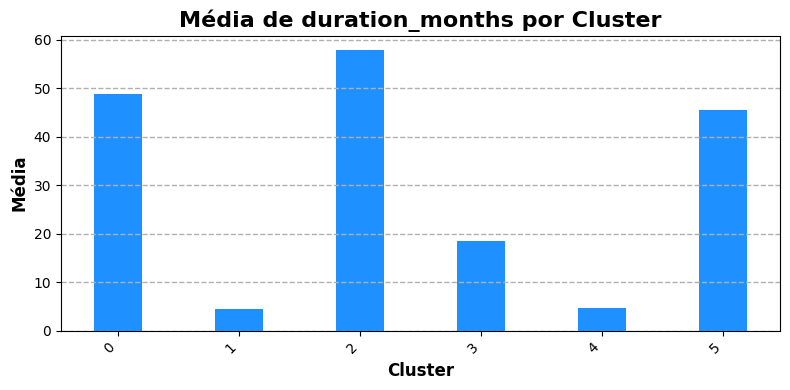

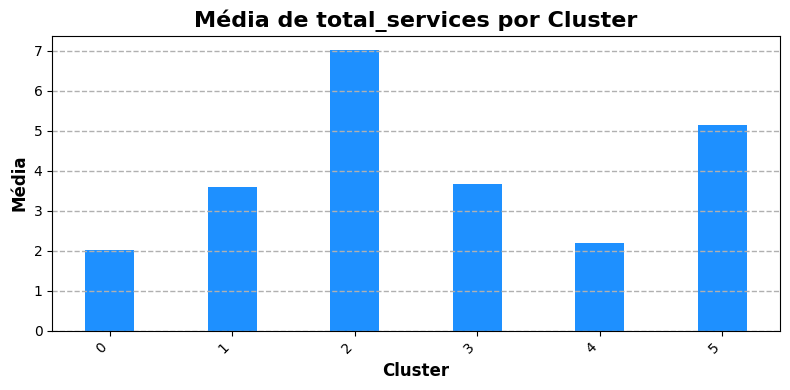

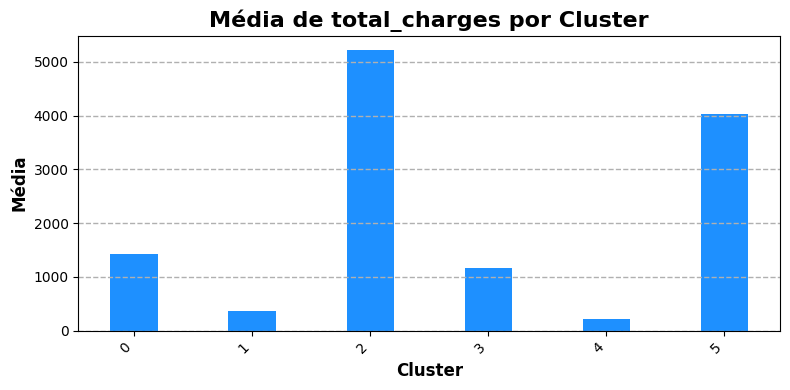

In [121]:
for col_name in numerical:
    cluster_graph_num(col_name)

**ANÁLISE DOS CLUSTERS:**

**Cluster 0:** 
Clientes acima de 2 anos de contrato ativo (maioria já acima de 3 anos, apresentando uma média de 50 meses) e que tem de 1 a 4 serviços contratados (média de 2). Estes clientes são positivos entre 1 e 5 categorias consideradas de risco dentre as 11 existentes, o que reflete num churn baixo de apenas 3%;

**Cluster 1:** 
Clientes abaixo de 1 ano de contrato ativo (maioria ainda abaixo de 6 meses, apresentando uma média de 4 meses) e que tem de 2 a 7 serviços contratados (média de 3,6). Estes clientes são positivos entre 7 e 11 categorias consideradas de risco dentre as 11 existentes, o que o torna um grupo de altíssimo risco de churn, 68,5%;

**Cluster 2:** 
Grupo com praticamente todos os clientes já com mais de 3 anos de contrato ativo (apresentando uma média de 58 meses) e que tem de 5 a 9 serviços contratados (média de 7). Mesmo com tantos serviços contratados, estes clientes são positivos somente entre 0 a 4 categorias consideradas de risco dentre as 11 existentes, o que reflete em apenas 8,5% de risco de churn;

**Cluster 3:** 
Grupo formado por clientes que tem de 1 a 2 anos de contrato ativo (com uma média de 19 meses) e que tem de 1 a 7 serviços contratados (média de 3,7). Estes clientes são positivos entre 3 e 9 categorias consideradas de risco dentre as 11 existentes, o que o torna um grupo de alto risco de churn, 26,1%;

**Cluster 4:**
Assim como o cluster 1, este grupo é formado por clientes que tem abaixo de 1 ano de contrato ativo (maioria ainda abaixo de 6 meses), que tem de 1 a 7 serviços contratados, porém com a maioria tendo de 1 a 4 serviços (média de 2,1). Estes clientes são positivos entre 2 e 6 categorias consideradas de risco dentre as 11 existentes, o que ainda faz com que seja um grupo de risco de churn considerável, 24,3%;

**Cluster 5:**
Assim como os grupos 0 e 2, os clientes deste grupo tem acima de 2 anos de contrato ativo (média de 46 meses) e que tem de 2 a 7 serviços contratados (média de 5,1). Estes clientes são positivos entre 5 e 9 categorias consideradas de risco dentre as 11 existentes, o que também o torna um grupo de alto risco de churn, 31,8%;


## Inclusão da coluna label nos conjuntos reais

In [122]:
# Exclusão de variáveis que não contribuem consideravelmente para o cluster
features_test_cluster = features_test.drop(drop_list, axis=1)

# Codificação
features_test_cluster.loc[:, categorical] = cluster_encoder.transform(features_test_cluster[categorical])

# Padronização
features_test_cluster[numerical] = features_test_cluster[numerical].astype(float)
features_test_cluster.loc[:, numerical] = cluster_scaler.transform(features_test_cluster[numerical])

In [123]:
# Predição dos clusters para o conjunto de teste
features_test_cluster['label'] = model_kmeans.predict(features_test_cluster)

In [124]:
train_label = features_train_cluster['label']
features_train = pd.concat([features_train, train_label], axis='columns')

test_label = features_test_cluster['label']
features_test = pd.concat([features_test, test_label], axis='columns')

# TRANSFORMAÇÃO DOS DADOS (conjuntos originais)

In [125]:
numerical = ['monthly_charges', 'duration_months', 'avg_charges', 'ratio_charges',
            'total_services', 'charges_per_services', 'total_charges',]

categorical = ['type', 'paperless_billing', 'payment_method', 'internet_service',
            'online_security', 'online_backup', 'device_protection', 'tech_support',
            'streaming_t_v', 'streaming_movies', 'partner', 'multiple_lines', 't_serv_lvl',
            'lonely', 'dependents', 'time_lvl', 'newbie_senior', 'auto_pay', 'cat_risk', 'phone']

In [126]:
# Codificação
encoder = OrdinalEncoder()
features_train.loc[:, categorical] = encoder.fit_transform(features_train[categorical])
features_test.loc[:, categorical] = encoder.transform(features_test[categorical])

In [127]:
# Padronização

features_train[numerical] = features_train[numerical].astype(float)
features_test[numerical] = features_test[numerical].astype(float)

scaler = StandardScaler()
features_train.loc[:, numerical] = scaler.fit_transform(features_train[numerical])
features_test.loc[:, numerical] = scaler.transform(features_test[numerical])

In [128]:
# Checando conjunto de dados
features_train.head(3)

type paperless_billing payment_method  monthly_charges  total_charges  \
1355  0.0               1.0            2.0        -1.507307      -0.930466   
1744  1.0               1.0            0.0         1.315214       0.821293   
4199  1.0               1.0            2.0         1.305246       1.516597   

      internet_service online_security online_backup device_protection  \
1355                 0             0.0           0.0               0.0   
1744                 2             1.0           1.0               1.0   
4199                 2             0.0           0.0               1.0   

     tech_support streaming_t_v streaming_movies  senior_citizen partner  \
1355          0.0           0.0              0.0               0     0.0   
1744          0.0           1.0              1.0               0     1.0   
4199          1.0           1.0              1.0               0     1.0   

     dependents multiple_lines phone  duration_months  avg_charges  \
1355        0.0            0.0   1.0        -0.973034    -1.447872   
1744        0.0            0.0   1.0         0.336675     1.151572   
4199        0.0            1.0   1.0         0.950602     1.163277   

      ratio_charges  total_services  charges_per_services price_label  \
1355      -0.925355       -1.367325              0.418547           0   
1744       0.478879        1.236479             -0.441535           4   
4199       0.410486        1.236479             -0.449586           4   

      time_lvl  t_serv_lvl  lonely  newbie_senior  mtm_senior  lonely_senior  \
1355         1           0       1              0           0              0   
1744         5          10       0              0           0              0   
4199         5          10       0              0           0              0   

      auto_pay  cat_risk label  
1355         0         5     4  
1744         1         4     2  
4199         0         4     2

# TRATAMENTO DO DESEQUILÍBRIO DE CLASSES

In [129]:
class_frequency = df_merged['churn'].value_counts(normalize=True)
print(class_frequency)

churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


Para tratar o Desequilíbrio das Classes, vamos utilizar as técnicas **SMOTE** e **Ajuste de Ponderação de Classe** (nos modelos que permitirem este ajuste). 

## Superamostragem SMOTE

A técnica SMOTE (Synthetic Minority Over-sampling Technique) é bastante utilizada para lidar com problemas de classificação em que há um desbalanceamento entre as classes, como é comum em problemas de churn.  
O SMOTE gera novas amostras sintéticas para a classe minoritária, em vez de apenas duplicar as amostras existentes. Isso é feito criando novos pontos interpolados entre amostras reais da classe minoritária, com base nos seus vizinhos mais próximos.

In [130]:
print(target_train.value_counts())

churn
0    4139
1    1486
Name: count, dtype: int64


### Conversão de Dados para float

In [131]:
features_train.columns

Index(['type', 'paperless_billing', 'payment_method', 'monthly_charges',
       'total_charges', 'internet_service', 'online_security', 'online_backup',
       'device_protection', 'tech_support', 'streaming_t_v',
       'streaming_movies', 'senior_citizen', 'partner', 'dependents',
       'multiple_lines', 'phone', 'duration_months', 'avg_charges',
       'ratio_charges', 'total_services', 'charges_per_services',
       'price_label', 'time_lvl', 't_serv_lvl', 'lonely', 'newbie_senior',
       'mtm_senior', 'lonely_senior', 'auto_pay', 'cat_risk', 'label'],
      dtype='object')

In [132]:
conversion = ['monthly_charges', 'total_charges', 'senior_citizen', 'duration_months', 'avg_charges', 'ratio_charges','total_services',
             'charges_per_services', 't_serv_lvl','lonely', 'time_lvl', 'newbie_senior', 'mtm_senior', 'lonely_senior','auto_pay',
             'type', 'paperless_billing', 'payment_method', 'internet_service', 'dependents', 'online_security', 'online_backup', 'device_protection',
             'tech_support', 'streaming_t_v', 'streaming_movies', 'partner', 'multiple_lines', 'label', 'price_label', 'cat_risk', 'phone']   

In [133]:
def to_float(df, column_list):

    for element in column_list:
        df[element] = df[element].astype('float')

In [134]:
to_float(features_train, conversion)
to_float(features_test, conversion)

In [135]:
smote = SMOTE(random_state=12345,
            sampling_strategy=0.8,   # Classe minoritária será 80% da majoritária após a superamostragem buscando aumentar um pouco mais o recall
            k_neighbors=5,           # Considerar os 5 vizinhos mais próximos para criar amostras sintéticas
            n_jobs=-1)               # Usar todos os núcleos disponíveis para o processamento

features_train_upsampled, target_train_upsampled = smote.fit_resample(features_train, target_train)

c:\Users\livia\Desktop\Projeto Final - TripleTen\.triple_ten\Lib\site-packages\imblearn\over_sampling\_smote\base.py:370: FutureWarning: The parameter `n_jobs` has been deprecated in 0.10 and will be removed in 0.12. You can pass an nearest neighbors estimator where `n_jobs` is already set instead.
  warnings.warn(


In [136]:
# Checagem do balanceamento de classes após superamostragem
print(target_train_upsampled.value_counts())

churn
0    4139
1    3311
Name: count, dtype: int64


# TREINAMENTO DOS MODELOS BÁSICOS

In [137]:
# Definição dos modelos básicos para primeira análise das métricas afim de avaliar o potencial do modelo

basic_models = [('LogisticRegression', LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')),
          ('DecisionTree', DecisionTreeClassifier(random_state=12345, class_weight='balanced')),
          ('RandomForest', RandomForestClassifier(random_state=12345, class_weight='balanced')),
          ('KNN', KNeighborsClassifier()),
          ('XGB', XGBClassifier(random_state=12345)),
          ('LightGBM', LGBMClassifier(random_state=12345, force_row_wise=True, verbose=0, class_weight='balanced')),
          ('CatBoost', CatBoostClassifier(verbose=False, random_state=12345))
          ]

#################### LogisticRegression ####################
auc_roc: 0.9188
f1: 0.8230
accuracy: 0.8379
precision: 0.7991
recall: 0.8484


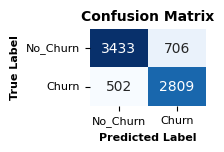

#################### DecisionTree ####################
auc_roc: 0.8582
f1: 0.8427
accuracy: 0.8593
precision: 0.8377
recall: 0.8478


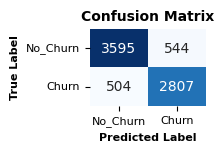

#################### RandomForest ####################
auc_roc: 0.9697
f1: 0.9023
accuracy: 0.9146
precision: 0.9184
recall: 0.8867


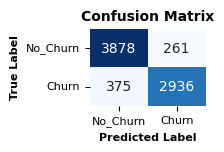

#################### KNN ####################
auc_roc: 0.9133
f1: 0.8281
accuracy: 0.8341
precision: 0.7675
recall: 0.8991


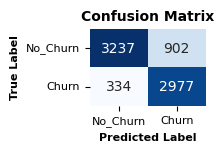

#################### XGB ####################
auc_roc: 0.9690
f1: 0.9024
accuracy: 0.9145
precision: 0.9155
recall: 0.8898


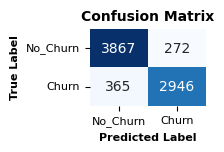

#################### LightGBM ####################
auc_roc: 0.9701
f1: 0.8997
accuracy: 0.9110
precision: 0.9015
recall: 0.8979


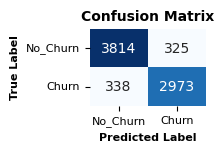

#################### CatBoost ####################
auc_roc: 0.9724
f1: 0.9028
accuracy: 0.9154
precision: 0.9225
recall: 0.8840


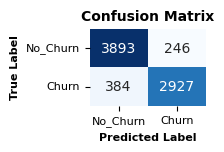

In [138]:
# Lista para armazenamento das métricas dos modelos básicos
basic_metrics = []

for name, model in basic_models:
    
    # Usando StratifiedKFold para manter a proporção das classes - utilizado para problemas de churn
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)
    
    # Treinar e Realizar predições usando validação cruzada
    cv_predicted_valid = cross_val_predict(model, features_train_upsampled, target_train_upsampled, cv=skf, method='predict')
    cv_probabilities_one_valid = cross_val_predict(model, features_train_upsampled, target_train_upsampled, cv=skf, method='predict_proba')[:, 1]
    
    
    # Métricas
    cv_auc_roc = roc_auc_score(target_train_upsampled, cv_probabilities_one_valid)
    cv_f1 = f1_score(target_train_upsampled, cv_predicted_valid)                         
    cv_accuracy = accuracy_score(target_train_upsampled, cv_predicted_valid)
    cv_precision = precision_score(target_train_upsampled, cv_predicted_valid)
    cv_recall = recall_score(target_train_upsampled, cv_predicted_valid)
    cv_conf_matrix = confusion_matrix(target_train_upsampled, cv_predicted_valid)
    
    # Armazenamento dos resultados na lista de métricas
    basic_metrics.append({
        "Model": name,
        "AUC_ROC": cv_auc_roc,
        "F1": cv_f1,
        "Accuracy": cv_accuracy,
        "Precision": cv_precision,
        "Recall": cv_recall})
    
    
    # Impressão das métricas
    print(f"#################### {name} ####################")
    print(f'auc_roc: {cv_auc_roc:.4f}')
    print(f'f1: {cv_f1:.4f}')
    print(f'accuracy: {cv_accuracy:.4f}')
    print(f'precision: {cv_precision:.4f}')
    print(f'recall: {cv_recall:.4f}')


    # Plotar matriz de confusão com heatmap
    plt.figure(figsize=(1.5, 1))
    
    ax = sns.heatmap(
        cv_conf_matrix, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        cbar=False)
    
    ax.set_xticklabels(['No_Churn', 'Churn'], rotation=0)
    ax.set_yticklabels(['No_Churn', 'Churn'], rotation=0)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    plt.xlabel('Predicted Label', fontsize=8, weight='bold')
    plt.ylabel('True Label', fontsize=8, weight='bold')
    plt.title('Confusion Matrix', fontsize=10, weight='bold')
    plt.show()

## Rede Neural

In [139]:
# Definindo o KFold estratificado
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)

# Listas para armazenar as métricas de cada fold
auc_roc_scores = []
f1_scores = []
accuracy_scores = []
precision_scores = []
recall_scores = []

for train_index, valid_index in skf.split(features_train_upsampled, target_train_upsampled):
    
    X_train, X_valid = features_train_upsampled.iloc[train_index], features_train_upsampled.iloc[valid_index]
    y_train, y_valid = target_train_upsampled.iloc[train_index], target_train_upsampled.iloc[valid_index]
    
    # Construção do modelo Keras
    keras_model = keras.models.Sequential()
    keras_model.add(keras.layers.Input(shape=(X_train.shape[1],)))
    keras_model.add(keras.layers.Dense(units=5, activation='sigmoid'))
    keras_model.add(keras.layers.Dense(units=3, activation='sigmoid'))
    keras_model.add(keras.layers.Dense(units=1, activation='sigmoid'))
    keras_model.compile(loss='binary_crossentropy', optimizer='sgd', metrics=['acc'])
    
    keras_model.fit(X_train, y_train, epochs=200, verbose=0)
    
    y_pred_proba = keras_model.predict(X_valid).flatten()
    y_pred = (y_pred_proba > 0.5).astype(int)
    
    # Calcular as métricas para o fold atual
    auc_roc_scores.append(roc_auc_score(y_valid, y_pred_proba))
    f1_scores.append(f1_score(y_valid, y_pred))
    accuracy_scores.append(accuracy_score(y_valid, y_pred))
    precision_scores.append(precision_score(y_valid, y_pred))
    recall_scores.append(recall_score(y_valid, y_pred))

# Calcular a média das métricas de todos os folds
print("AUC_ROC:", np.mean(auc_roc_scores))
print("F1:", np.mean(f1_scores))
print("Accuracy:", np.mean(accuracy_scores))
print("Precision:", np.mean(precision_scores))
print("Recall:", np.mean(recall_scores))


47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 891us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 943us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 894us/step
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
AUC_ROC: 0.919082249513375
F1: 0.8135482142272383
Accuracy: 0.8334228187919462
Precision: 0.8102409659884471
Recall: 0.8184700140804637


In [140]:
keras_result_ = ['Keras',
                np.mean(auc_roc_scores),
                np.mean(f1_scores),
                np.mean(accuracy_scores),
                np.mean(precision_scores),
                np.mean(recall_scores)]

df_keras_index = ['Model', 'AUC_ROC', 'F1', 'Accuracy', 'Precision', 'Recall']
df_keras_results = pd.DataFrame(data=keras_result_, index=df_keras_index)

## Seleção dos melhores modelos para tuning

In [141]:

metrics = {
       "Model": ["LogisticRegression", "DecisionTree", "RandomForest", "KNN", "XGB", "LightGBM", "CatBoost"],

       "AUC_ROC": [basic_metrics[0]['AUC_ROC'], basic_metrics[1]['AUC_ROC'],basic_metrics[2]['AUC_ROC'],
              basic_metrics[3]['AUC_ROC'],basic_metrics[4]['AUC_ROC'], basic_metrics[5]['AUC_ROC'],basic_metrics[6]['AUC_ROC']],

       "F1": [basic_metrics[0]['F1'], basic_metrics[1]['F1'],basic_metrics[2]['F1'], basic_metrics[3]['F1'],
              basic_metrics[4]['F1'], basic_metrics[5]['F1'],basic_metrics[6]['F1']],

       "Accuracy": [basic_metrics[0]['Accuracy'], basic_metrics[1]['Accuracy'], basic_metrics[2]['Accuracy'],
              basic_metrics[3]['Accuracy'],basic_metrics[4]['Accuracy'], basic_metrics[5]['Accuracy'],basic_metrics[6]['Accuracy']],

       "Precision": [basic_metrics[0]['Precision'], basic_metrics[1]['Precision'],basic_metrics[2]['Precision'], basic_metrics[3]['Precision'],
              basic_metrics[4]['Precision'], basic_metrics[5]['Precision'],basic_metrics[6]['Precision']],

       "Recall": [basic_metrics[0]['Recall'], basic_metrics[1]['Recall'],basic_metrics[2]['Recall'], basic_metrics[3]['Recall'],
              basic_metrics[4]['Recall'], basic_metrics[5]['Recall'],basic_metrics[6]['Recall']]}

In [142]:
# Criando DataFrame com resultados dos modelos
df_metrics = pd.DataFrame(metrics)

# Concatenar dfs de resultados e ordenar pelo valor de AUC-ROC
basic_metrics_df = pd.concat([df_metrics, df_keras_results.T])
basic_metrics_df = basic_metrics_df.sort_values(by="AUC_ROC", ascending=False)

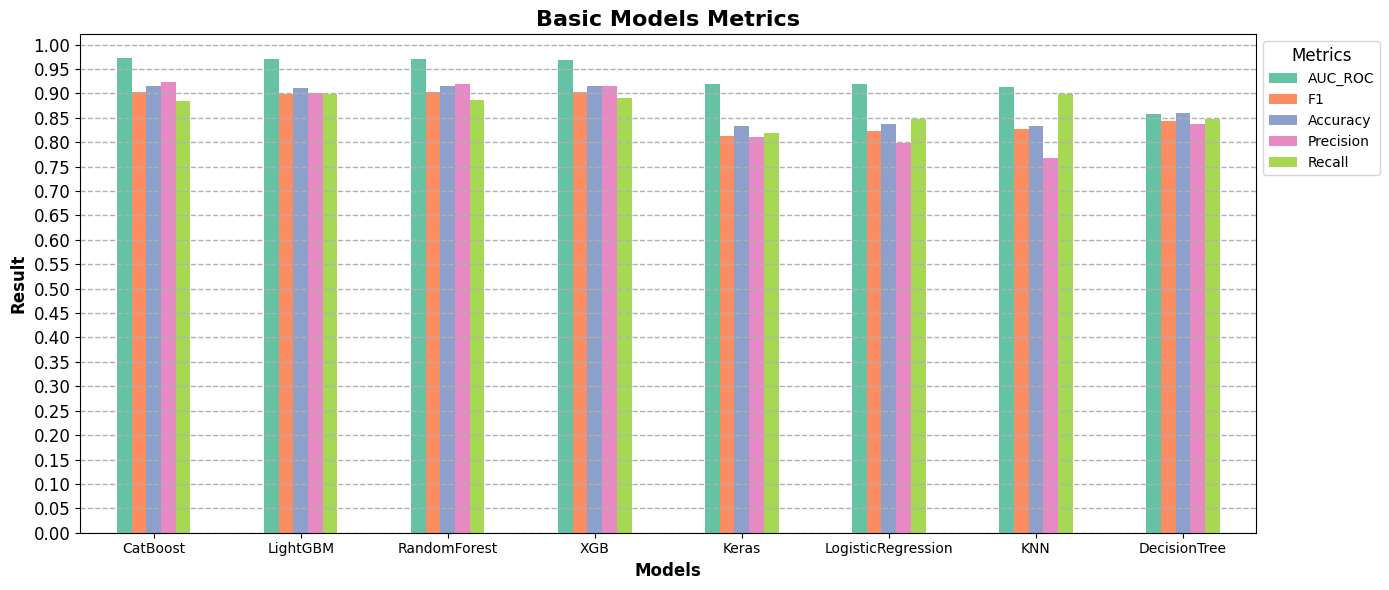

In [143]:
colors = sns.color_palette("Set2") # Paleta de cores suave

ax = basic_metrics_df.plot(
    kind='bar',
    x='Model',
    figsize=[14, 6],
    width=0.5,
    color=colors)

# Títulos
ax.set_title('Basic Models Metrics', fontsize=16, weight='bold')
ax.set_xlabel('Models', fontsize=12, weight='bold')
ax.set_ylabel('Result', fontsize=12, weight='bold')

# Rótulos
ax.set_xticklabels(basic_metrics_df['Model'], rotation=0)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=12)

# Legenda
ax.legend(title='Metrics', title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# Grades
ax.grid(True, which='both', linestyle='--', linewidth=1, axis='y')
ax.set_yticks(np.arange(0, 1.05, 0.05)) #intervalo de 5 em 5

plt.tight_layout()
plt.show()


Analisando-se os resultados obtidos com os modelos básicos, a opção foi selecionar os 4 melhores para o Tuning, ou seja, o ajuste de hiperparâmetros com o objetivo de melhorar ainda mais os resultados obtidos.

Os modelos selecionados são: **RandomForest, XGB, LightGBM e CatBoost**.

## Feature importance

In [144]:
selected_models = [('RandomForest', RandomForestClassifier(random_state=12345, class_weight='balanced')),
                ('XGB', XGBClassifier(random_state=12345)),
                ('LightGBM', LGBMClassifier(random_state=12345, force_row_wise=True, verbose=0, class_weight='balanced')),
                ('CatBoost', CatBoostClassifier(verbose=False, random_state=12345))]

In [145]:
def plot_importance(model, features, num=len(features)):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(8, 6))
    sns.set_theme(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",ascending=False)[0:num])
    
    plt.title(f'Feature Importance - {model.__class__.__name__}', fontsize=12, weight='bold')
    plt.tight_layout()
    plt.show(block=True)

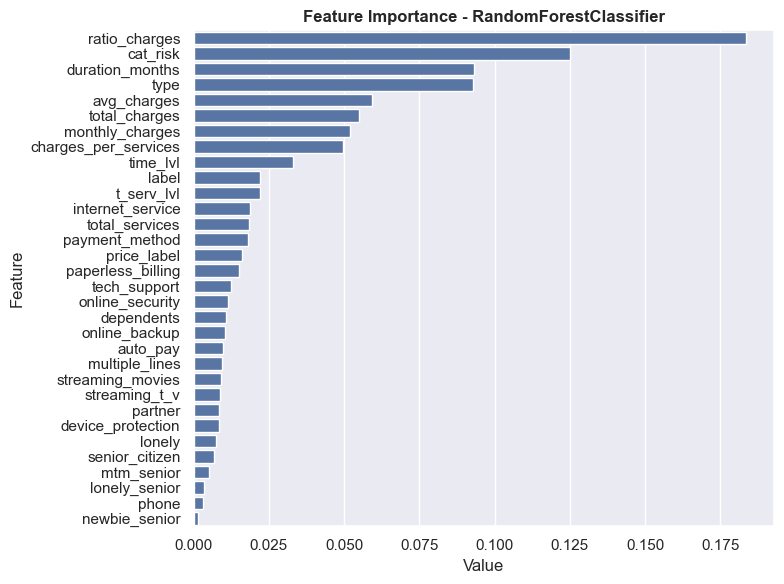

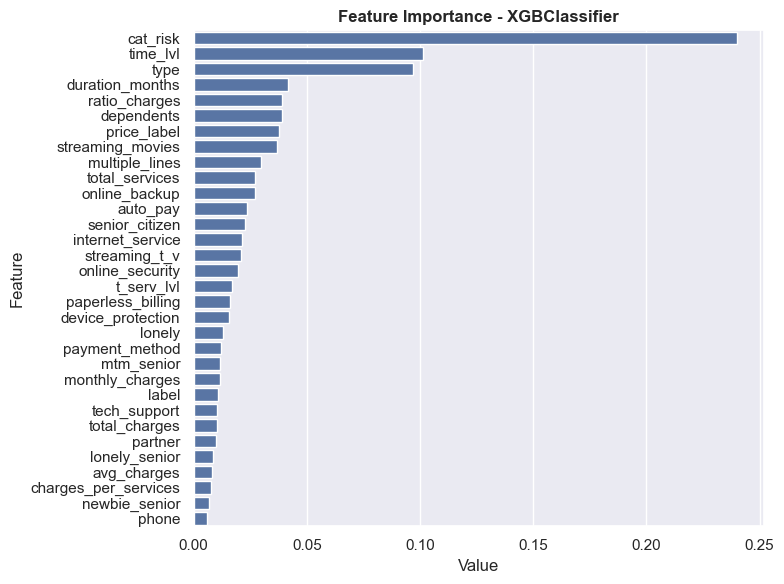

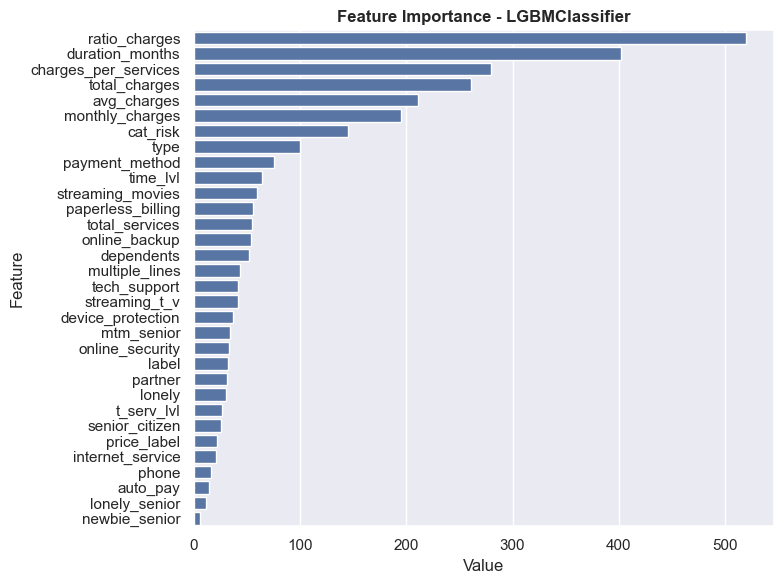

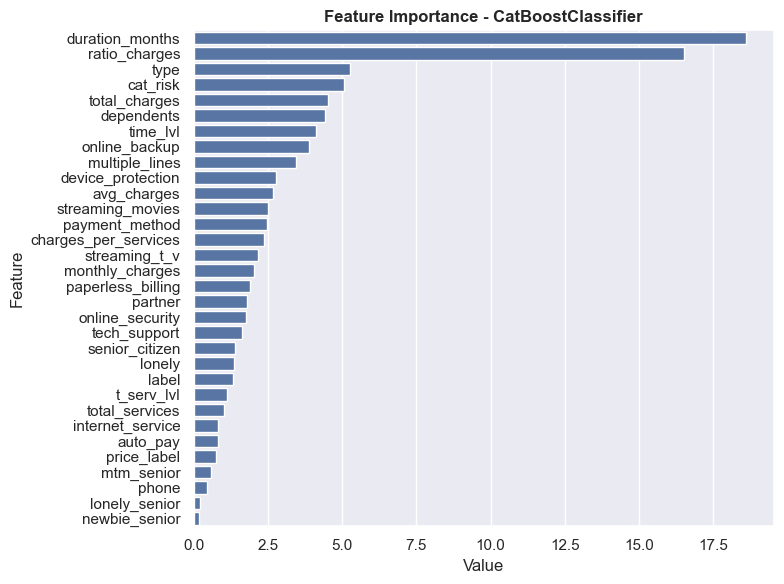

In [146]:
for name, model in selected_models:
    model.fit(features_train_upsampled, target_train_upsampled)
    plot_importance(model, features_train_upsampled)

# AJUSTE DE HIPERPARÂMETROS (Tuning)

In [147]:
def tuning(model, param_grid, features_train, target_train):

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=12345)
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=skf, n_jobs=-1, scoring='roc_auc')

    # Treinamento do modelo e predições
    grid_search.fit(features_train, target_train)
    best_model = grid_search.best_estimator_
    predict_valid = cross_val_predict(best_model, features_train, target_train, cv=skf, method='predict')
    probabilities_one_valid = cross_val_predict(best_model, features_train, target_train, cv=skf, method='predict_proba')[:, 1]
    
    # Métricas
    auc_roc = roc_auc_score(target_train, probabilities_one_valid)
    f1 = f1_score(target_train, predict_valid)                         
    accuracy = accuracy_score(target_train, predict_valid)
    precision = precision_score(target_train, predict_valid)
    recall = recall_score(target_train, predict_valid)
    conf_matrix = confusion_matrix(target_train, predict_valid)        
        
    print('Melhores Hiperparâmetros:', grid_search.best_params_)
    print(f'auc_roc: {auc_roc:.4f}')
    print(f'f1: {f1:.4f}')
    print(f'accuracy: {accuracy:.4f}')
    print(f'precision: {precision:.4f}')
    print(f'recall: {recall:.4f}')
    
    
    # Plotar matriz de confusão com heatmap
    plt.figure(figsize=(1.5, 1))
    
    ax = sns.heatmap(
        conf_matrix, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        cbar=False)
    
    ax.set_xticklabels(['No_Churn', 'Churn'], rotation=0)
    ax.set_yticklabels(['No_Churn', 'Churn'], rotation=0)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    plt.xlabel('Predicted Label', fontsize=8, weight='bold')
    plt.ylabel('True Label', fontsize=8, weight='bold')
    plt.title('Confusion Matrix', fontsize=10, weight='bold')
    plt.show()
    
    return auc_roc, f1, accuracy, precision, recall

## RandomForestClassifier

In [148]:
model_forest = RandomForestClassifier(random_state=12345, class_weight='balanced')

forest_param_grid = {'n_estimators': [250, 300, 500],
                    'criterion': ['gini', 'entropy'],
                    'max_depth': [None, 1, 3],
                    'min_samples_split': [2, 4, 6],
                    'min_samples_leaf': [1, 2]}

Melhores Hiperparâmetros: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
auc_roc: 0.9712
f1: 0.9031
accuracy: 0.9150
precision: 0.9156
recall: 0.8910


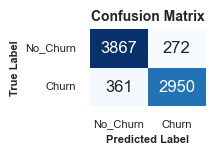

In [149]:
rf_metrics = tuning(model_forest, forest_param_grid, features_train_upsampled, target_train_upsampled)

## XGBClassifier

In [150]:
model_xgb = XGBClassifier(random_state=12345, n_estimators=300)

xgb_param_grid = {'learning_rate': [0.01, 0.1],
                    'min_split_loss': [0, 1, 2],
                    'max_depth': [10, 15],
                    'subsample': [0.1, 0.5, 1],
                    'reg_lambda': [0, 1],
                    'reg_alpha': [0, 1],
                    'max_leaves': [0, 1],
                    'num_parallel_tree': [1, 3]}

c:\Users\livia\Desktop\Projeto Final - TripleTen\.triple_ten\Lib\site-packages\numpy\ma\core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Melhores Hiperparâmetros: {'learning_rate': 0.1, 'max_depth': 10, 'max_leaves': 0, 'min_split_loss': 2, 'num_parallel_tree': 3, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.5}
auc_roc: 0.9711
f1: 0.9028
accuracy: 0.9145
precision: 0.9121
recall: 0.8937


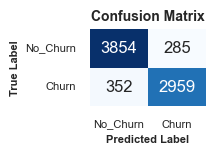

In [151]:
xgb_metrics = tuning(model_xgb, xgb_param_grid, features_train_upsampled, target_train_upsampled)

## LGBMClassifier

In [152]:
model_lgbm =  LGBMClassifier(random_state=12345, force_row_wise=True, verbose=-1, class_weight='balanced')

lgbm_param_grid = {'num_iterations': [150, 250],
                    'max_depth': [-1, 5], 
                    'num_leaves': [30, 80, 120],
                    'learning_rate': [0.01, 0.1, 0.3],
                    'min_child_samples': [20, 50],
                    'pos_bagging_fraction': [0.1, 1.0],
                    'neg_bagging_fraction': [0.1, 1.0],
                    'subsample': [0.6, 0.8]
                    }

Melhores Hiperparâmetros: {'learning_rate': 0.1, 'max_depth': 5, 'min_child_samples': 20, 'neg_bagging_fraction': 0.1, 'num_iterations': 150, 'num_leaves': 30, 'pos_bagging_fraction': 0.1, 'subsample': 0.6}
auc_roc: 0.9717
f1: 0.8998
accuracy: 0.9110
precision: 0.9005
recall: 0.8991


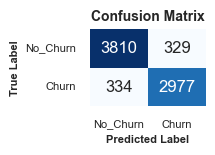

In [153]:
import warnings
warnings.filterwarnings("ignore", message="Found `num_iterations` in params.")

lgbm_metrics = tuning(model_lgbm, lgbm_param_grid, features_train_upsampled, target_train_upsampled)

## CatBoostClassifier

In [154]:
model_catboost =  CatBoostClassifier(verbose=False, random_state=12345, early_stopping_rounds=10)

catboost_param_grid = {'iterations': [300, 1000],
                        'learning_rate': [0.01, 0.1],
                        'depth': [None, 4, 8],
                        'l2_leaf_reg': [1, 3, 5],
                        'border_count': [32, 50, 100]}

Melhores Hiperparâmetros: {'border_count': 100, 'depth': 8, 'iterations': 1000, 'l2_leaf_reg': 1, 'learning_rate': 0.01}
auc_roc: 0.9729
f1: 0.9040
accuracy: 0.9164
precision: 0.9226
recall: 0.8861


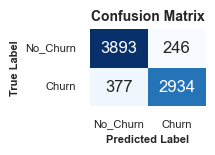

In [155]:
catboost_metrics = tuning(model_catboost, catboost_param_grid, features_train_upsampled, target_train_upsampled)

## Comparativo dos modelos após Tuning

In [156]:
tunned_metrics = {
       "Model": ["RandomForest", "XGB", "LightGBM", "CatBoost"],
       
       "AUC_ROC": [rf_metrics[0], xgb_metrics[0], lgbm_metrics[0], catboost_metrics[0]],
       
       "F1": [rf_metrics[1], xgb_metrics[1],lgbm_metrics[1], catboost_metrics[1]],
       
       "Accuracy": [rf_metrics[2], xgb_metrics[2], lgbm_metrics[2], catboost_metrics[2]],
       
       "Precision": [rf_metrics[3], xgb_metrics[3], lgbm_metrics[3], catboost_metrics[3]],
       
       "Recall": [rf_metrics[4], xgb_metrics[4], lgbm_metrics[4], catboost_metrics[4]]
       }

In [157]:
# Criando DataFrame com resultados dos modelos
df_tunned_metrics = pd.DataFrame(tunned_metrics)

df_tunned_metrics = df_tunned_metrics.sort_values(by="AUC_ROC", ascending=False)

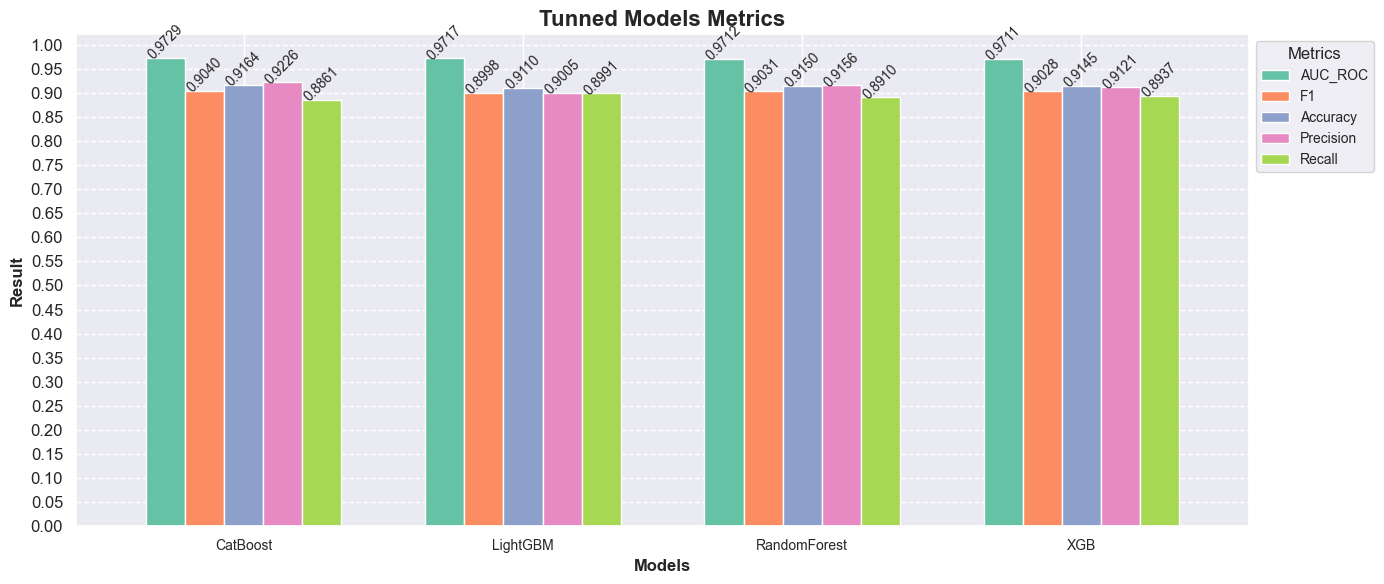

In [158]:
colors = sns.color_palette("Set2") # Paleta de cores suave

ax = df_tunned_metrics.plot(
    kind='bar',
    x='Model',
    figsize=[14, 6],
    width=0.7,
    color=colors)

# Títulos
ax.set_title('Tunned Models Metrics', fontsize=16, weight='bold')
ax.set_xlabel('Models', fontsize=12, weight='bold')
ax.set_ylabel('Result', fontsize=12, weight='bold')

# Rótulos
ax.set_xticklabels(df_tunned_metrics['Model'], rotation=0)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=12)

# Legenda
ax.legend(title='Metrics', title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# Grades
ax.grid(True, which='both', linestyle='--', linewidth=1, axis='y')
ax.set_yticks(np.arange(0, 1.05, 0.05)) #intervalo de 5 em 5

# Adicionar rótulos de valores em cada barra
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.4f'),  # Formato com duas casas decimais
        (p.get_x() + p.get_width() / 2., p.get_height()),  # Posição do texto
        ha='center', va='center', 
        xytext=(0, 11),  # Deslocamento do texto (0 em x, 5 em y)
        textcoords='offset points',
        rotation=45,
        fontsize=10
    )

plt.tight_layout()
plt.show()


# TESTE DOS MODELOS COM CONJUNTO DE TESTE

In [159]:
best_models = [('RandomForest', RandomForestClassifier(random_state=12345,
                                                        class_weight='balanced',
                                                        criterion= 'entropy',
                                                        max_depth= None,
                                                        min_samples_leaf= 1,
                                                        min_samples_split= 2,
                                                        n_estimators = 500)),
                
                
                ('XGB', XGBClassifier(random_state=12345,
                                        learning_rate= 0.1,
                                        max_depth= 10,
                                        max_leaves=0,
                                        min_split_loss= 2,
                                        n_estimators=300,
                                        num_parallel_tree= 3,
                                        reg_alpha= 0,
                                        reg_lambda= 0,
                                        subsample= 0.5)),
                
                
                ('LightGBM', LGBMClassifier(random_state=12345,
                                            force_row_wise=True,
                                            verbose=-1,
                                            class_weight='balanced',
                                            learning_rate= 0.1,
                                            max_depth= 5,
                                            min_child_samples= 20,
                                            num_iterations= 150,
                                            num_leaves= 30,
                                            subsample=0.6,
                                            neg_bagging_fraction= 0.1,
                                            pos_bagging_fraction= 0.1)),
                
                
                ('CatBoost', CatBoostClassifier(random_state=12345,
                                                verbose=False,
                                                early_stopping_rounds=10,
                                                border_count=100,
                                                depth= 8,
                                                iterations= 1000,
                                                l2_leaf_reg= 1,
                                                learning_rate= 0.01))
                ]


########## RandomForest ##########
test_auc_roc: 0.9367
test_f1: 0.7956
test_accuracy: 0.8948
test_precision: 0.8446
test_recall: 0.7520


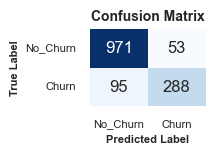

########## XGB ##########
test_auc_roc: 0.9393
test_f1: 0.7907
test_accuracy: 0.8913
test_precision: 0.8305
test_recall: 0.7546


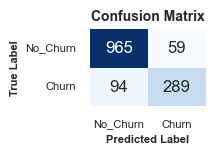

########## LightGBM ##########
test_auc_roc: 0.9420
test_f1: 0.8016
test_accuracy: 0.8934
test_precision: 0.8123
test_recall: 0.7911


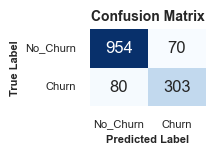

########## CatBoost ##########
test_auc_roc: 0.9394
test_f1: 0.7950
test_accuracy: 0.8948
test_precision: 0.8466
test_recall: 0.7493


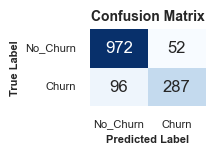

In [160]:
test_metrics = []

for name, model in best_models:
    
    model.fit(features_train_upsampled, target_train_upsampled)

    test_predict = model.predict(features_test)
    test_probabilities = model.predict_proba(features_test)[:, 1]

    test_auc_roc = roc_auc_score(target_test, test_probabilities)
    test_f1 = f1_score(target_test, test_predict)                         
    test_accuracy = accuracy_score(target_test, test_predict)
    test_precision = precision_score(target_test, test_predict)
    test_recall = recall_score(target_test, test_predict)
    test_conf_matrix = confusion_matrix(target_test, test_predict)
    
    
    # Armazenamento dos resultados na lista de métricas
    test_metrics.append({
        "Model": name,
        "AUC_ROC": test_auc_roc,
        "F1": test_f1,
        "Accuracy": test_accuracy,
        "Precision": test_precision,
        "Recall": test_recall})
    

    # Impressão das métricas
    print(f"########## {name} ##########")
    print(f'test_auc_roc: {test_auc_roc:.4f}')
    print(f'test_f1: {test_f1:.4f}')
    print(f'test_accuracy: {test_accuracy:.4f}')
    print(f'test_precision: {test_precision:.4f}')
    print(f'test_recall: {test_recall:.4f}')
    
    # Plotar matriz de confusão com heatmap
    plt.figure(figsize=(1.5, 1))
    
    ax = sns.heatmap(
        test_conf_matrix, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        cbar=False)
    
    ax.set_xticklabels(['No_Churn', 'Churn'], rotation=0)
    ax.set_yticklabels(['No_Churn', 'Churn'], rotation=0)
    ax.tick_params(axis='x', labelsize=8)
    ax.tick_params(axis='y', labelsize=8)
    
    plt.xlabel('Predicted Label', fontsize=8, weight='bold')
    plt.ylabel('True Label', fontsize=8, weight='bold')
    plt.title('Confusion Matrix', fontsize=10, weight='bold')
    plt.show()

In [161]:
test_metrics_dict = {
       "Model": ["RandomForest", "XGB", "LightGBM", "CatBoost"],
       
       "AUC_ROC": [test_metrics[0]['AUC_ROC'], test_metrics[1]['AUC_ROC'],test_metrics[2]['AUC_ROC'], test_metrics[3]['AUC_ROC']],
       
       "F1": [test_metrics[0]['F1'], test_metrics[1]['F1'],test_metrics[2]['F1'], test_metrics[3]['F1']],
       
       "Accuracy": [test_metrics[0]['Accuracy'], test_metrics[1]['Accuracy'], test_metrics[2]['Accuracy'], test_metrics[3]['Accuracy']],
       
       "Recall": [test_metrics[0]['Recall'], test_metrics[1]['Recall'],test_metrics[2]['Recall'], test_metrics[3]['Recall']],
       
       "Precision": [test_metrics[0]['Precision'], test_metrics[1]['Precision'],test_metrics[2]['Precision'], test_metrics[3]['Precision']]}

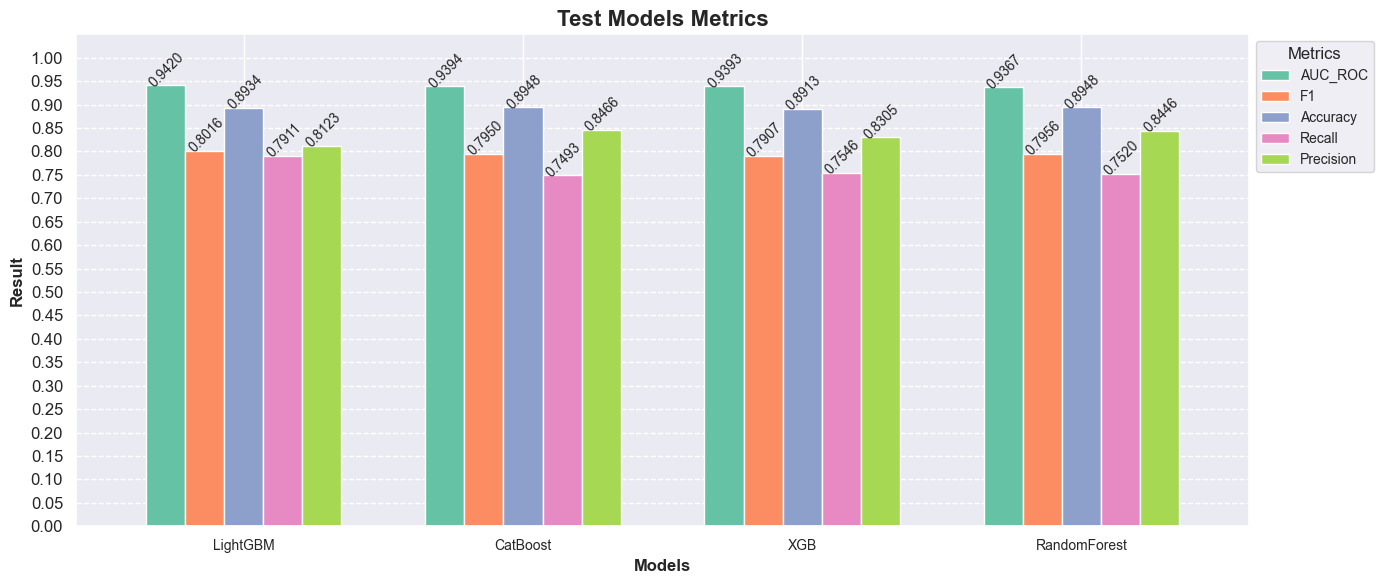

In [162]:
# DataFrame com resultados dos modelos
df_test_metrics = pd.DataFrame(test_metrics_dict).sort_values('AUC_ROC', ascending=False)


colors = sns.color_palette("Set2") # Paleta de cores suave

ax = df_test_metrics.plot(
    kind='bar',
    x='Model',
    figsize=[14, 6],
    width=0.7,
    color=colors)

# Títulos
ax.set_title('Test Models Metrics', fontsize=16, weight='bold')
ax.set_xlabel('Models', fontsize=12, weight='bold')
ax.set_ylabel('Result', fontsize=12, weight='bold')

# Rótulos
ax.set_xticklabels(df_test_metrics['Model'], rotation=0)
ax.tick_params(axis='x', labelsize=10)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylim(0.5, 1.05) 

# Legenda
ax.legend(title='Metrics', title_fontsize=12, fontsize=10, loc='upper left', bbox_to_anchor=(1, 1))

# Grades
ax.grid(True, which='both', linestyle='--', linewidth=1, axis='y')
ax.set_yticks(np.arange(0, 1.05, 0.05)) #intervalo de 5 em 5

# Adicionar rótulos de valores em cada barra
for p in ax.patches:
    ax.annotate(
        format(p.get_height(), '.4f'),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center', va='center', 
        xytext=(1, 11),  # Deslocamento do texto
        textcoords='offset points',
        rotation=45,
        fontsize=10)

plt.tight_layout()
plt.show()


# CONCLUSÃO

Os resultados obtidos no projeto foram muito satisfatórios e o AUC-ROC objetivo foi alcançado por todos os modelos, então todos atendem às nossas necessidades.  
Porém, precisamos definir um melhor modelo dentre os criados e, analisando as métricas obtidas, percebemos que **O melhor modelo, foi o LightGBM**, pois além de obter o melhor valor de AUC-ROC, também obteve o melhor resultado de F1, uma acurácia muito próxima à dos outros modelos e seu Recall se destacou muito dos demais. Portanto, conforme descrito no planejamento, uma questão importante é que o modelo tenha uma sensibilidade maior para predizer clientes com possibilidade de churn, pois o custo da perda de um cliente é elevado, portanto, é preferível ter mais Falsos Positivos do que Falsos Negativos, ou seja, é melhor oferecer promoção para um cliente que não sofreria churn do que não oferecer e ele cancelar seu contrato.

## Feature Importance do modelo escolhido

In [163]:
chosen_model = LGBMClassifier(random_state=12345,
                                force_row_wise=True,
                                verbose=-1,
                                class_weight='balanced',
                                learning_rate= 0.1,
                                max_depth= 5,
                                min_child_samples= 20,
                                num_iterations= 150,
                                num_leaves= 30,
                                subsample=0.6,
                                neg_bagging_fraction= 0.1,
                                pos_bagging_fraction= 0.1)

chosen_model.fit(features_train_upsampled, target_train_upsampled)

LGBMClassifier(class_weight='balanced', force_row_wise=True, max_depth=5,
               neg_bagging_fraction=0.1, num_iterations=150, num_leaves=30,
               pos_bagging_fraction=0.1, random_state=12345, subsample=0.6,
               verbose=-1)

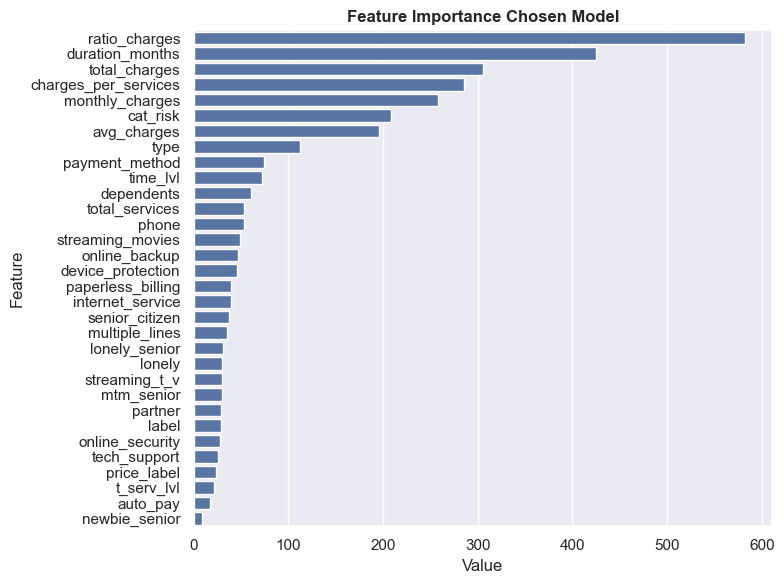

In [164]:
chosen_model_feat_imp = pd.DataFrame({'Value': chosen_model.feature_importances_, 'Feature': features_train_upsampled.columns})

plt.figure(figsize=(8, 6))
sns.set_theme(font_scale=1)
sns.barplot(x="Value", y="Feature", data=chosen_model_feat_imp.sort_values(by="Value",ascending=False)[0:len(features_train_upsampled)])
    
plt.title(f'Feature Importance Chosen Model', fontsize=12, weight='bold')
plt.tight_layout()
plt.show(block=True)

Podemos perceber que dentre as 10 features mais importantes para a predição do modelo, 6 foram criadas no processo de feature engineering, sendo que 2 delas foram as principais features.

Isso nos confirma que os bons resultados alcançados neste projeto foram consequência das informações levantadas na EDA, que possibilitaram a criação de diversas colunas relevantes durante o Feature Engineering, que por sua vez, também possibilitou o levantamento de muitas informações importantes, sendo possível observar detalhes que seriam imperceptíveis somente com as colunas originais.

## Explicabilidade

Vamos plotar um gráfico que mostra a contribuição das variáveis para as previsões do modelo usando SHAP (SHapley Additive exPlanations). Ele ajuda a entender quais variáveis são mais importantes para o modelo e como cada uma delas influencia as previsões.

* Valores positivos indicam que a variável aumenta a probabilidade da previsão positiva, neste caso, churn.
* Valores negativos indicam que a variável diminui essa probabilidade.
* A cor de cada ponto representa o valor da variável, o quanto é alto ou baixo.

In [165]:
import warnings
warnings.filterwarnings("ignore", message="LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray")

explainer = shap.TreeExplainer(chosen_model)
shap_values = explainer.shap_values(features_train_upsampled)

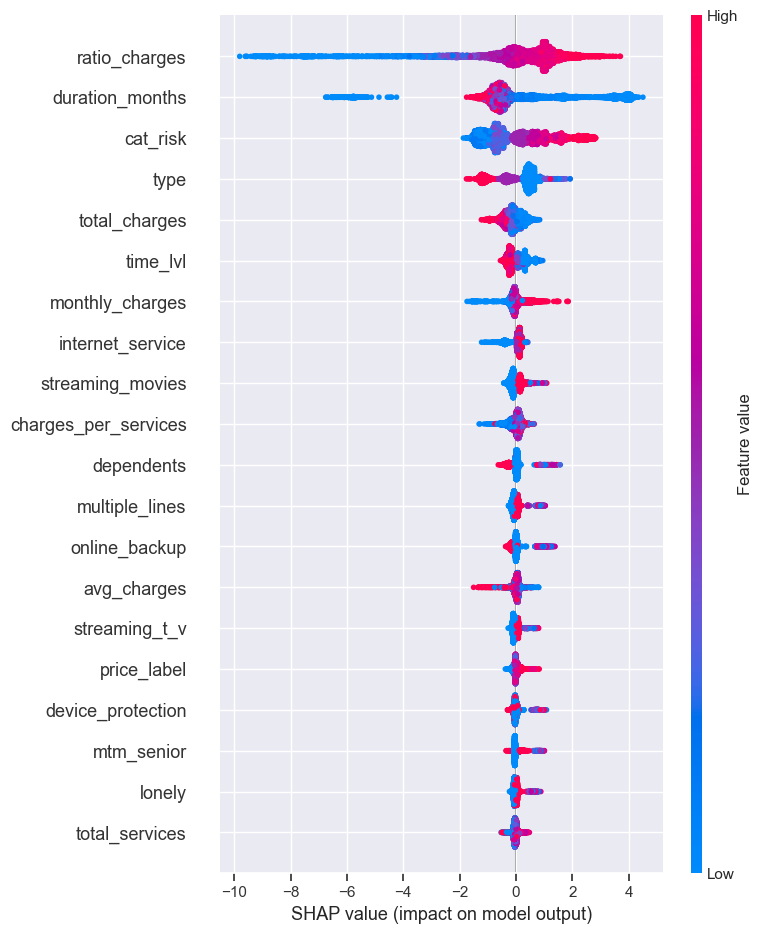

In [166]:
shap.summary_plot(shap_values, features_train_upsampled)

### Exemplo para amostra de índice 2

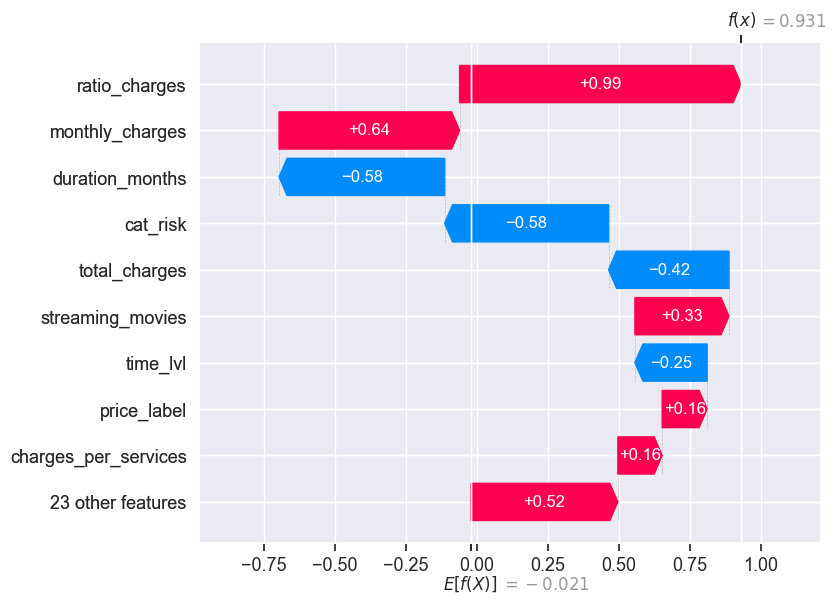

In [167]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[2], feature_names=features_train_upsampled.columns)

## Análise do IC do modelo com bootstrapping

In [168]:
dist_metrics = []

for i in range(1000):
    model = chosen_model
    x_sample = features_train_upsampled.sample(n = len(features_train_upsampled), replace = True)
    y_sample = target_train_upsampled[x_sample.index]
    
    model.fit(x_sample, y_sample)
    y_pred_test = model.predict(features_test)
    y_pred_proba_test = model.predict_proba(features_test)[:, 1]

    auc_roc = roc_auc_score(target_test, y_pred_proba_test)
    f1 = f1_score(target_test, y_pred_test)                         
    acc = accuracy_score(target_test, y_pred_test)
    recall = recall_score(target_test, y_pred_test)
    precision = precision_score(target_test, y_pred_test)
    
    # Armazenamento dos resultados na lista de métricas
    dist_metrics.append({
        "AUC_ROC": auc_roc,
        "F1": f1,
        "Accuracy": acc,
        "Recall": recall,
        "Precision": precision})

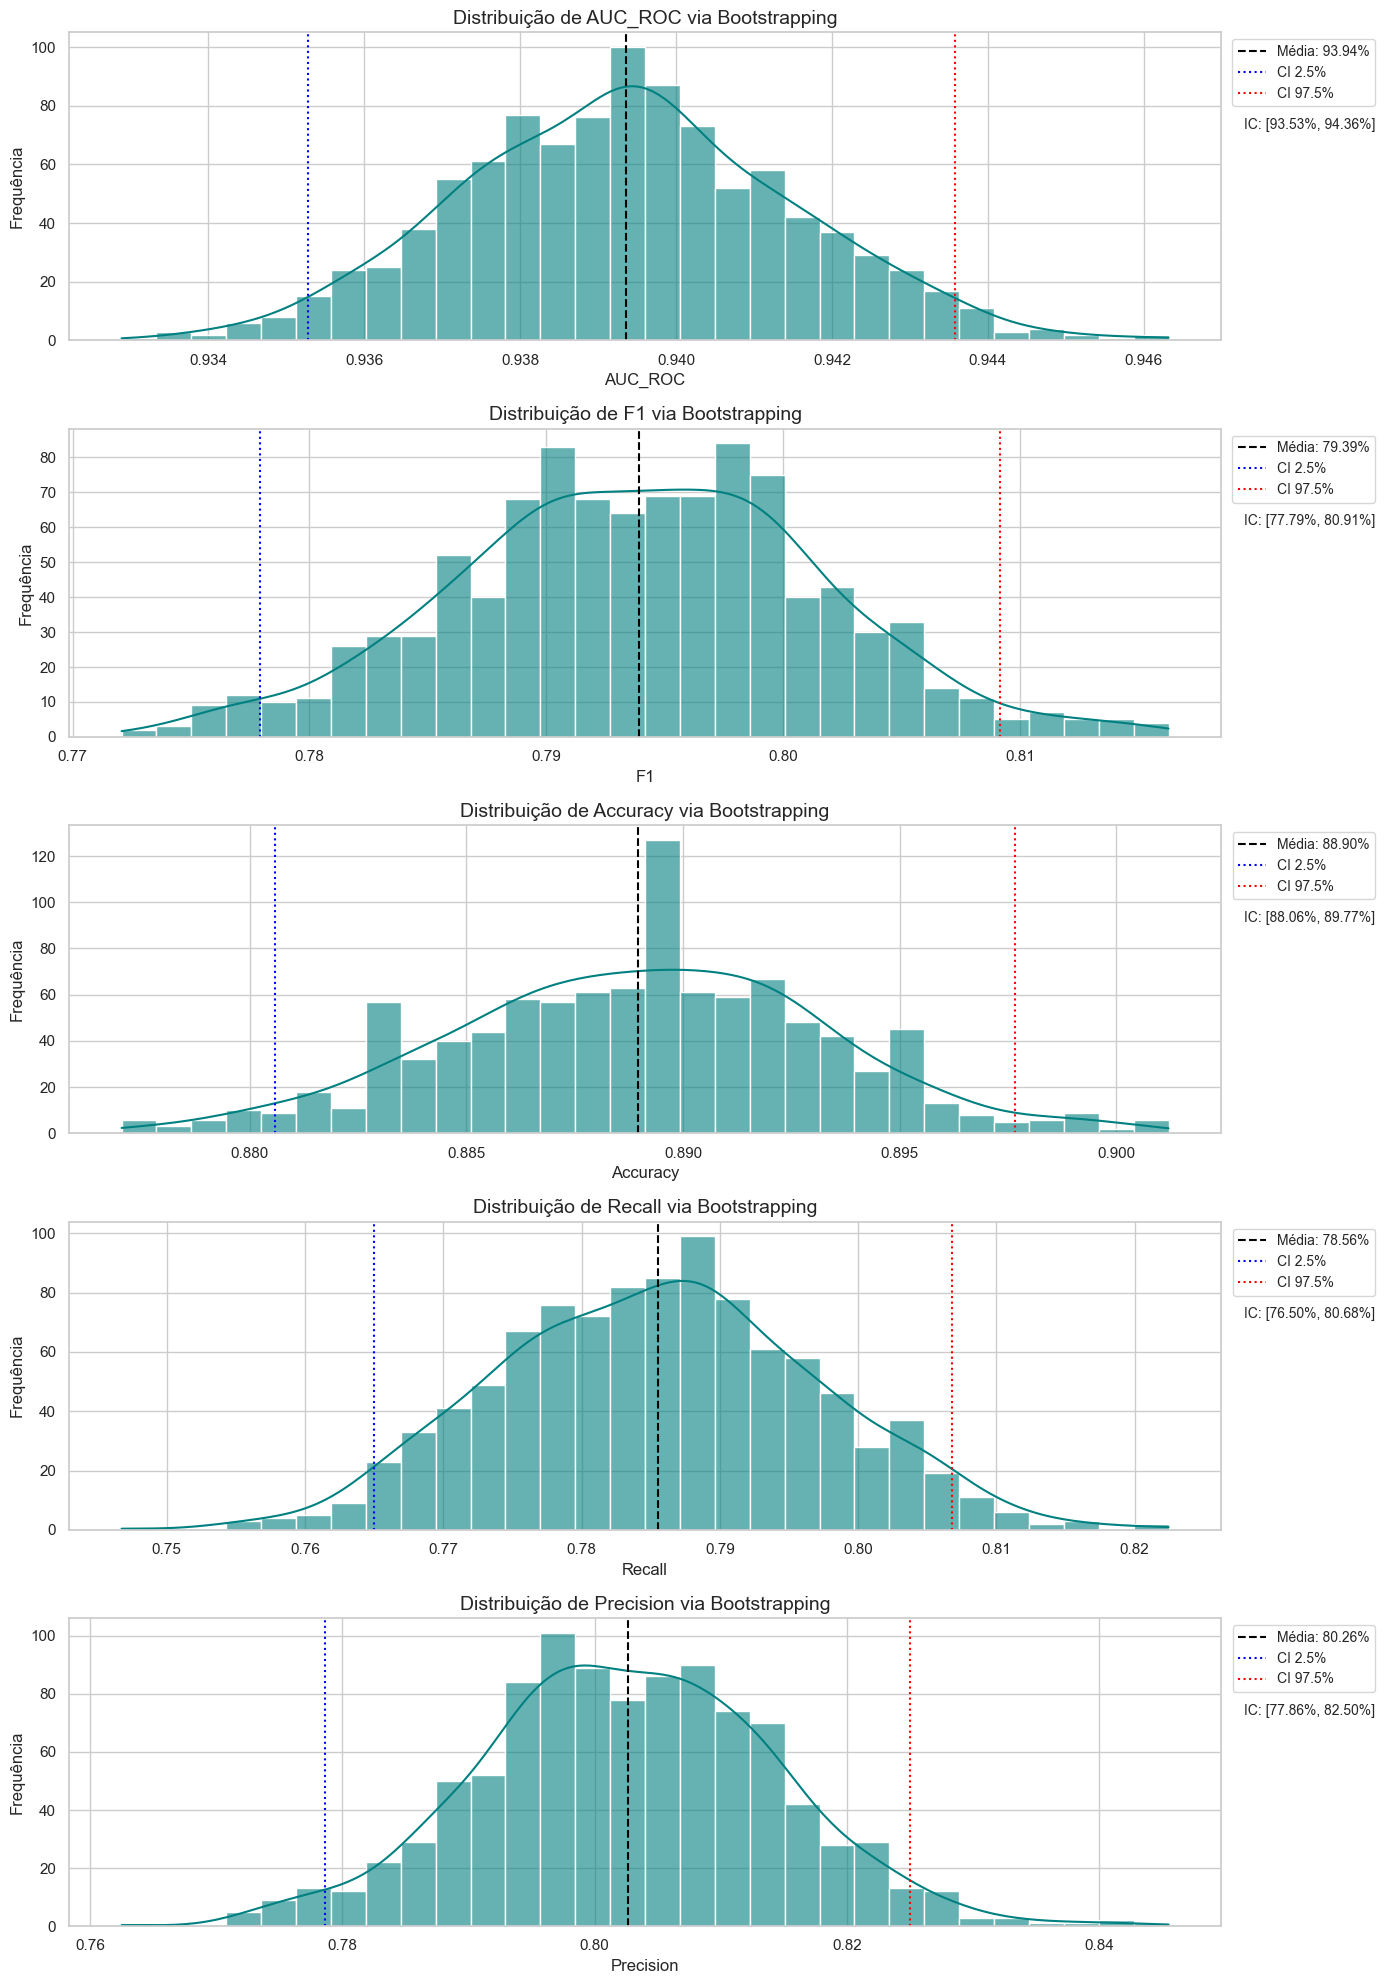

In [169]:
df_dist = pd.DataFrame(dist_metrics)

sns.set_theme(style="whitegrid")

num_cols = len(df_dist.columns)
fig, axes = plt.subplots(nrows=num_cols, ncols=1, figsize=(14, 4 * num_cols))

for ax, col_name in zip(axes, df_dist.columns):
    sns.histplot(data=df_dist, x=col_name, kde=True, bins=30, ax=ax, color='teal', alpha=0.6)

    # Média e intervalos de confiança
    media = np.mean(df_dist[col_name])
    ci_lower = np.percentile(df_dist[col_name], 2.5)
    ci_upper = np.percentile(df_dist[col_name], 97.5)

    # Linha para a média e intervalos de confiança
    ax.axvline(media, color='black', linestyle='--', label=f"Média: {media:.2%}")
    ax.axvline(ci_lower, color='blue', linestyle=':', label=f"CI 2.5%")
    ax.axvline(ci_upper, color='red', linestyle=':', label=f"CI 97.5%")

    ax.legend(loc='upper right', bbox_to_anchor=(1.14, 1), fontsize=10)

    # Impressão do intervalo de confiança
    ax.annotate(
        f"IC: [{ci_lower:.2%}, {ci_upper:.2%}]", 
        xy=(1.02, 0.7), 
        xycoords='axes fraction', 
        fontsize=10, 
        ha='left', 
        va='center',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

    ax.set_title(f"Distribuição de {col_name} via Bootstrapping", fontsize=14)
    ax.set_xlabel(col_name, fontsize=12)
    ax.set_ylabel("Frequência", fontsize=12)

plt.tight_layout()
plt.show()

Os intervalos de confiança são relativamente estreitos para todas as métricas, indicando que o modelo é estável mesmo com diferentes amostras do conjunto de dados.

# PRÓXIMOS PASSOS

Os Resultados alcançados no projeto foram muito satisfatórios, mas ainda existem possibilidades de aprofundamentos nos estudos, assim como um melhor refino do modelo através das técnicas de estudo de features executadas acima, o que poderá ser realizado posteriormente para a obtenção de um resultado ainda melhor.